# Proyecto Series Temporales SuperReatail Corp.

Hoy es tu primer día de trabajo como científico de datos en SuperRetail Corp.⚡, una empresa familiar especializada en el comercio retail online. Después de realizar un análisis exhaustivo del mercado utilizando reglas comerciales, se están planteando llevar a cabo una ampliación de capital. Para ello, quieren saber cuál es el valor que puede tener su empresa en el futuro expresado por sus ventas esperadas y quieren que les ayudes a abordar esta cuestión. El objetivo consiste en predecir cuál será su nivel de ventas totales en el país UK durante el próximo mes.

La empresa te distribuye una muestra representativa de las ventas diarias por producto en los mercados más importantes durante los últimos años. Para este modelo de prueba, se ha fijado un horizonte de predicción de un mes teniendo en cuenta la última fecha de transacciones disponible en los datos (el 9 de Diciembre de 2023).

Debes construir una métrica adecuada para llevar a cabo la tarea utilizando los datos que se ofrecen así como seleccionar y justificar el modelo predictivo que mejor se ajuste al objetivo.

| **Nombre de Variable** | **Descripción**                                                                                                           |
|------------------------|---------------------------------------------------------------------------------------------------------------------------|
| **InvoiceNo**  | Numero de factura. Un número integral de 6 dígitos asignado de forma única a cada transacción. Si comienza con la letra 'c', **indica una cancelación**. |
| **StockCode**    | Codigo de Stock. Un número integral de 5 dígitos asignado de forma única a cada producto distinto.                                          |
| **Description**        | _Descripción del producto_.                                                                                               |
| **Date**              | _Fecha diaria_.                                                                                                           |
| **TotalSales**    | **Total de Ventas diarias**.                                                                                              |
| **Country**               | El nombre del país que constituye **mercado prioritario**.                                                                |


# 1. Introducción y Preprocesamiento: Análisis descriptivo
- Énfasis en variables temporales y estacionalidad.
- Análisis de autocorrelación y autocorrelación parcial.
- Descomposición de los componentes de la serie temporal


Es importante apoyar tus ideas con visualizaciones




### 1.1.1 Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math

# Prophet
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components
from prophet.diagnostics import cross_validation, performance_metrics

# Stats models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error , mean_absolute_percentage_error, root_mean_squared_error
from math import sqrt
import random

# Boosting
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

# Configuración adicional para eliminar cuadrículas
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'tab10'
# Configuración de la paleta de colores
sns.set_palette("tab10")
pio.templates.default = "plotly_dark"
rcParams['figure.figsize'] = 15, 12





import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

In [97]:
pd.options.display.max_rows = 100

### 1.1.2 Leer Datos CSV.

In [98]:
df = pd.read_csv(r"C:\Users\Usuario\Desktop\Nuclio\MODULO5TIMESERIES\retail_todo_ventas.csv")
df_descrip  = pd.read_csv(r"C:\Users\Usuario\Desktop\Nuclio\MODULO5TIMESERIES\prod_dict.csv")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19160\796754080.py:1: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



### 1.1.3 Inspección Inicial de los Datos

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394330 entries, 0 to 394329
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   InvoiceNo   394330 non-null  object 
 1   StockCode   394330 non-null  object 
 2   Date        394330 non-null  object 
 3   Country     394330 non-null  object 
 4   TotalSales  394330 non-null  float64
dtypes: float64(1), object(4)
memory usage: 15.0+ MB


In [100]:
df_descrip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StockCode    3922 non-null   object
 1   Description  3922 non-null   object
dtypes: object(2)
memory usage: 61.4+ KB


### 1.1.4 Eliminación de Duplicados

In [101]:
df_descrip[df_descrip.StockCode.duplicated(keep=False)].sort_values("StockCode")

StockCode                          Description
38      16156L                       WRAP, CAROUSEL
39      16156L                        WRAP CAROUSEL
94      17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
95      17107D         FLOWER FAIRY 5 DRAWER LINERS
96      17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
...        ...                                  ...
3576    90014A         SILVER M.O.P. ORBIT NECKLACE
3577    90014B         GOLD M PEARL  ORBIT NECKLACE
3578    90014B           GOLD M.O.P. ORBIT NECKLACE
3579    90014C          SILVER/BLACK ORBIT NECKLACE
3580    90014C      SILVER AND BLACK ORBIT NECKLACE

[432 rows x 2 columns]

In [102]:
df_descrip = df_descrip.drop_duplicates(subset='StockCode')

In [103]:
df_descrip.StockCode.duplicated().sum()

0

In [104]:
df_descrip

StockCode                         Description
0            10002          INFLATABLE POLITICAL GLOBE
1            10080            GROOVY CACTUS INFLATABLE
2            10120                        DOGGY RUBBER
3            10125             MINI FUNKY DESIGN TAPES
4            10133        COLOURING PENCILS BROWN TUBE
...            ...                                 ...
3917  GIFT_0001_40  Dotcomgiftshop Gift Voucher £40.00
3918  GIFT_0001_50  Dotcomgiftshop Gift Voucher £50.00
3919             M                              Manual
3920          POST                             POSTAGE
3921             S                             SAMPLES

[3697 rows x 2 columns]

In [105]:
df.StockCode.nunique()

3697

In [106]:
num_unique_stockcodes = df.StockCode.nunique()
num_rows_descrip = df_descrip.shape[0]

print(f"El número de valores únicos en StockCode es {num_unique_stockcodes} y es igual al número de filas en df_descrip, que es {num_rows_descrip}.")

El número de valores únicos en StockCode es 3697 y es igual al número de filas en df_descrip, que es 3697.


In [107]:
df.drop_duplicates(inplace=True)
df_descrip.drop_duplicates(inplace=True)

In [108]:
df.duplicated().sum()

0

In [109]:
df_descrip.duplicated().sum()

0

En un primer análisis de los datos proporcionados, me di cuenta de que la tabla de descripciones contiene códigos de stock duplicados. Esto causaba que al juntar los dos dataframes se crearan filas duplicadas. Decidí eliminar todos los códigos duplicados y quedarme solo con una descripción del producto, ya que, tras un vistazo rápido, se puede observar que son maneras diferentes de describir el mismo producto y no aportan mucho más al proyecto. 

También me aseguro de que los valores únicos de la columna StockCode y las filas de df_descrip coincidan para garantizar que al juntar los dataframes no haya problemas de duplicados.

### 1.1.5 Gestión de Valores Nulos


In [110]:
df.isna().sum()

InvoiceNo     0
StockCode     0
Date          0
Country       0
TotalSales    0
dtype: int64

In [111]:
df_descrip.isna().sum()

StockCode      0
Description    0
dtype: int64

In [112]:
df.dropna(inplace=True)
df_descrip.dropna(inplace=True)

Comprobamos que no hay ningún valor nulo; sin embargo, los eliminamos por si acaso.

### 1.1.6 Join de Dataframes.

In [113]:
df_com = df.merge(df_descrip, how="left",on="StockCode")

In [114]:
# Convertir la columna Date al formato datetime
df_com['Date'] = pd.to_datetime(df_com['Date'])

In [115]:
# Establecer la columna Date como índice
df_com.set_index('Date', inplace=True)

In [116]:
df_com

InvoiceNo StockCode         Country  TotalSales  \
Date                                                         
2022-12-01    536365     21730  United Kingdom       25.50   
2022-12-01    536365     22752  United Kingdom       15.30   
2022-12-01    536365     71053  United Kingdom       20.34   
2022-12-01    536365    84029E  United Kingdom       20.34   
2022-12-01    536365    84029G  United Kingdom       20.34   
...              ...       ...             ...         ...   
2023-12-09    581587     22730          France       15.00   
2023-12-09    581587     23254          France       16.60   
2023-12-09    581587     23255          France       16.60   
2023-12-09    581587     23256          France       16.60   
2023-08-12   A563185         B  United Kingdom    11062.06   

                                    Description  
Date                                             
2022-12-01    GLASS STAR FROSTED T-LIGHT HOLDER  
2022-12-01         SET 7 BABUSHKA NESTING BOXES  
2022-12-01                  WHITE METAL LANTERN  
2022-12-01       RED WOOLLY HOTTIE WHITE HEART.  
2022-12-01  KNITTED UNION FLAG HOT WATER BOTTLE  
...                                         ...  
2023-12-09           ALARM CLOCK BAKELIKE IVORY  
2023-12-09         CHILDRENS CUTLERY DOLLY GIRL  
2023-12-09      CHILDRENS CUTLERY CIRCUS PARADE  
2023-12-09           CHILDRENS CUTLERY SPACEBOY  
2023-08-12                      Adjust bad debt  

[394328 rows x 5 columns]

### 1.1.7 Comprobacion de Facturas canceladas

In [117]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394328 entries, 2022-12-01 to 2023-08-12
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    394328 non-null  object 
 1   StockCode    394328 non-null  object 
 2   Country      394328 non-null  object 
 3   TotalSales   394328 non-null  float64
 4   Description  394328 non-null  object 
dtypes: float64(1), object(4)
memory usage: 18.1+ MB


In [118]:
# Convertir la columna 'InvoiceNo' a tipo string para poder usar el método 'startswith()'
df_com['InvoiceNo'] = df_com['InvoiceNo'].astype(str)

# Comprobar si hay alguna factura que comienza con 'C'
cancelaciones = df_com[df_com['InvoiceNo'].str.startswith('C')]

# Verificar si hay alguna cancelación
if not cancelaciones.empty:
    print("Se encontraron cancelaciones:")
    print(cancelaciones)
else:
    print("No hay ninguna factura cancelada.")

No hay ninguna factura cancelada.


## 1.2 Analisis Global

En un primer vistazo  a los datos vamos a agrupar las ventas por dias totales de todos los productos y de todos los paises.

In [119]:
df_com[df_com["InvoiceNo"] == "536544"]

InvoiceNo StockCode         Country  TotalSales  \
Date                                                         
2022-12-01    536544     11001  United Kingdom       10.08   
2022-12-01    536544    17011F  United Kingdom        4.21   
2022-12-01    536544    17012A  United Kingdom        7.53   
2022-12-01    536544    17012B  United Kingdom        5.02   
2022-12-01    536544    18098C  United Kingdom       11.82   
...              ...       ...             ...         ...   
2022-12-01    536544    90161A  United Kingdom        5.09   
2022-12-01    536544     90194  United Kingdom        4.24   
2022-12-01    536544    90200A  United Kingdom        4.24   
2022-12-01    536544    90200C  United Kingdom        4.24   
2022-12-01    536544       DOT  United Kingdom      569.77   

                                   Description  
Date                                            
2022-12-01         ASSTD DESIGN RACING CAR PEN  
2022-12-01   ORIGAMI SANDLEWOOD INCENSE+FLOWER  
2022-12-01  ORIGAMI VANILLA INCENSE/CANDLE SET  
2022-12-01  ORIGAMI JASMINE INCENSE/CANDLE SET  
2022-12-01      PORCELAIN BUTTERFLY OIL BURNER  
...                                        ...  
2022-12-01    ANT COPPER RED BOUDICCA BRACELET  
2022-12-01  SILVER LARIAT BLACK STONE EARRINGS  
2022-12-01          PURPLE SWEETHEART BRACELET  
2022-12-01            BLUE SWEETHEART BRACELET  
2022-12-01                      DOTCOM POSTAGE  

[369 rows x 5 columns]

Esta comprobación verifica que un solo número de factura contenga la venta de varios artículos y que incluya los gastos de envío asociados a la misma.

Antes de seguir con el analisis, voy a eliminar varias filas que contienen datas de pagos y que creo que no van a aportar informacion relevante de las ventas. Como son:

- "AMAZONFEE" Amazon cobra a los vendedores una tarifa por cada venta realizada a través de su plataforma. Esta tarifa es un porcentaje del precio de venta del producto y varía según la categoría del producto.
- "DOT" Se refiere a los costos de envío asociados con las ventas realizadas a través de una plataforma en línea (e-commerce).
- "POST" Gastos de franqueo o envío. Este término se refiere a los costos incurridos por enviar productos a los clientes. Incluye los costos de transporte y manejo.
- "SAMPLES" Muestras de productos. Este término se refiere a los productos que se proporcionan como muestras gratuitas a clientes potenciales, con fines de marketing o promoción.
- "CARRIAGE" Gastos de transporte o envío. Similar a "Postage", pero puede referirse específicamente a los costos de transporte de mercancías desde el proveedor al almacén o desde el almacén al cliente.
- "BANK CHARGES" Cargos bancarios. Estos son los costos asociados con las transacciones financieras realizadas a través de bancos, incluyendo comisiones por transferencias, manejo de cuentas, y otros servicios bancarios.
- "B" (Adjust bad debt) Ajuste de deuda incobrable. Este término se refiere a los ajustes contables realizados para contabilizar deudas que se consideran incobrables y que deben ser eliminadas de los registros financieros.

In [120]:
# Lista de StockCodes a eliminar
codes_to_remove = ['AMAZONFEE', 'B', 'BANK CHARGES', 'C2', 'DOT', 'M', 'POST', 'S']

In [121]:
df_com = df_com[~df_com['StockCode'].isin(codes_to_remove)]

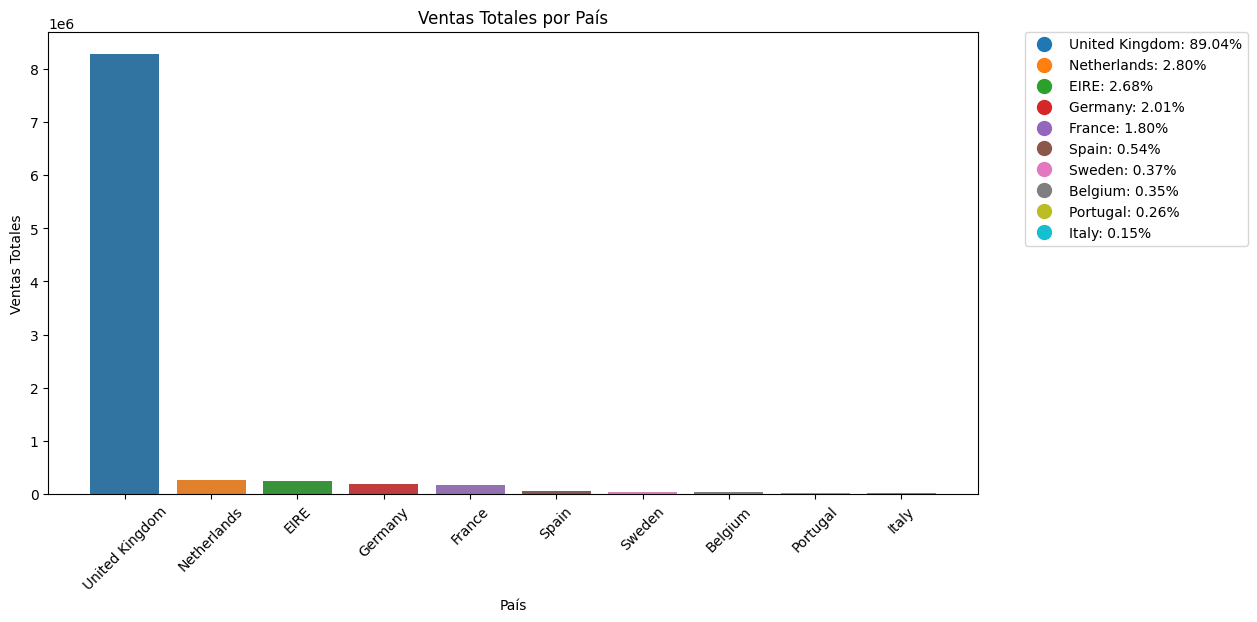

In [122]:
# A continuación, agrupa los datos por país y suma las ventas totales por país
sales_by_country = df_com.groupby('Country')['TotalSales'].sum().reset_index()

# Calcula el porcentaje de ventas de cada país
total_sales = sales_by_country['TotalSales'].sum()
sales_by_country['Percentage'] = (sales_by_country['TotalSales'] / total_sales) * 100

# Ordena los datos por ventas totales en orden descendente
sales_by_country = sales_by_country.sort_values(by='TotalSales', ascending=False)

# Asigna un color diferente a cada país
palette = sns.color_palette("tab10", len(sales_by_country))

# Configura el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crea el gráfico de barras con Seaborn
barplot = sns.barplot(x='Country', y='TotalSales', data=sales_by_country, palette=palette, hue='Country', dodge=False, legend=False)

# Añade etiquetas y título al gráfico
plt.xlabel('País')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por País')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para que sean legibles

# Añade la leyenda con el porcentaje de ventas
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=palette[i], 
            label="{:s}: {:.2f}%".format(sales_by_country["Country"].iloc[i], 
            sales_by_country["Percentage"].iloc[i]) )[0]  for i in range(len(sales_by_country))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Muestra el gráfico
plt.show()


En el gráfico, podemos observar que tenemos datos de 10 países. Sin duda, el país con el mayor volumen de ventas es el Reino Unido, que representa casi el 90% del total. Además, "EIRE" es el nombre irlandés para Irlanda y se utiliza en contextos donde se emplean nombres en su idioma original.

Como parte del proyecto, realizaremos predicciones para los próximos 30 días solo para UK , ya que es el pais mas reprensetativo.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19160\700245672.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19160\700245672.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



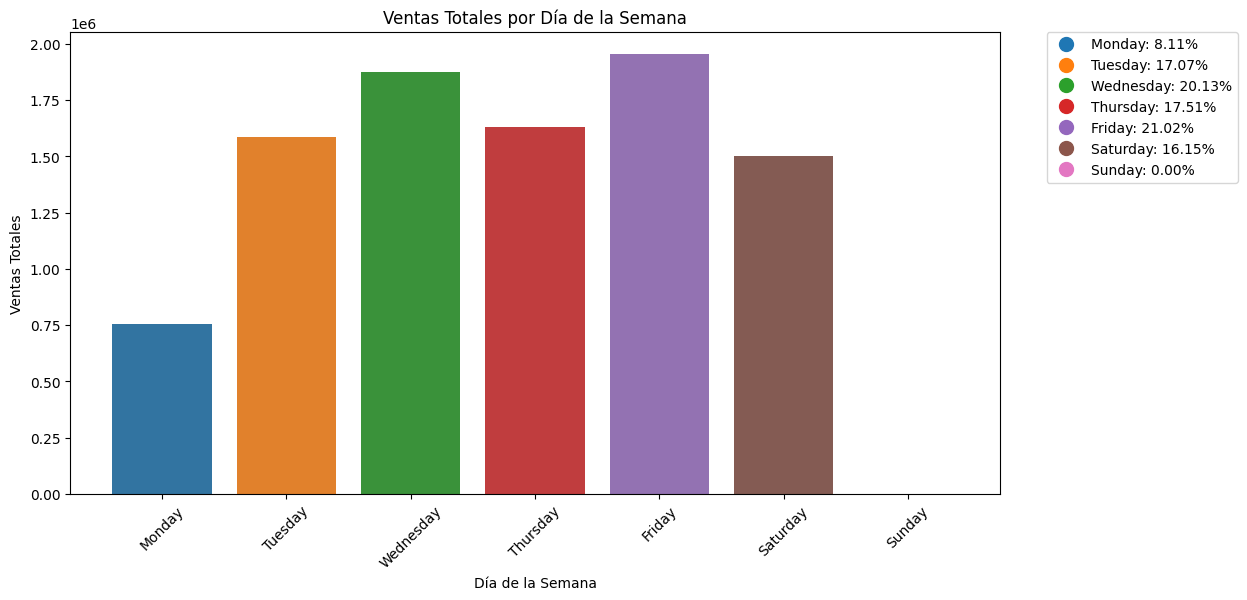

In [123]:

# Asegúrate de que el índice de tu dataframe sea un DatetimeIndex
df_com.index = pd.to_datetime(df_com.index)

# Extraer el día de la semana del índice usando dayofweek
df_com['DayOfWeek'] = df_com.index.dayofweek

# Crear un mapa de números de días de la semana a nombres de días
day_name_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Convertir números a nombres de días
df_com['DayOfWeek'] = df_com['DayOfWeek'].map(day_name_map)

# Agrupar por día de la semana y sumar las ventas
sales_by_day = df_com.groupby('DayOfWeek')['TotalSales'].sum().reset_index()

# Asegurarse de que todos los días de la semana estén presentes, incluso si no hay ventas (rellena con 0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day = sales_by_day.set_index('DayOfWeek').reindex(days_order, fill_value=0).reset_index()

# Calcular el porcentaje de ventas de cada día respecto al total de ventas
total_sales = sales_by_day['TotalSales'].sum()
sales_by_day['Percentage'] = (sales_by_day['TotalSales'] / total_sales) * 100

# Asigna un color diferente a cada día
palette = sns.color_palette("tab10", len(sales_by_day))

# Configura el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crea el gráfico de barras con Seaborn
barplot = sns.barplot(x='DayOfWeek', y='TotalSales', data=sales_by_day, palette=palette, hue='DayOfWeek', dodge=False, legend=False)

# Añade etiquetas y título al gráfico
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Día de la Semana')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para que sean legibles

# Añade la leyenda con el porcentaje de ventas
patches = [plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=palette[i], 
            label="{:s}: {:.2f}%".format(sales_by_day["DayOfWeek"].iloc[i], 
            sales_by_day["Percentage"].iloc[i]) )[0] for i in range(len(sales_by_day))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Muestra el gráfico
plt.show()

La gráfica muestra una clara estacionalidad semanal en las ventas, destacando que los lunes tienen la menor actividad con solo un 8.11% del total semanal. Las ventas aumentan significativamente el martes (17.07%) y miércoles (20.13%), manteniéndose altas el jueves (17.51%). El viernes registra el pico más alto de ventas con un 21.02%, probablemente debido a la proximidad del fin de semana. Las ventas disminuyen ligeramente el sábado (16.15%) y son inexistentes el domingo (0.00%).

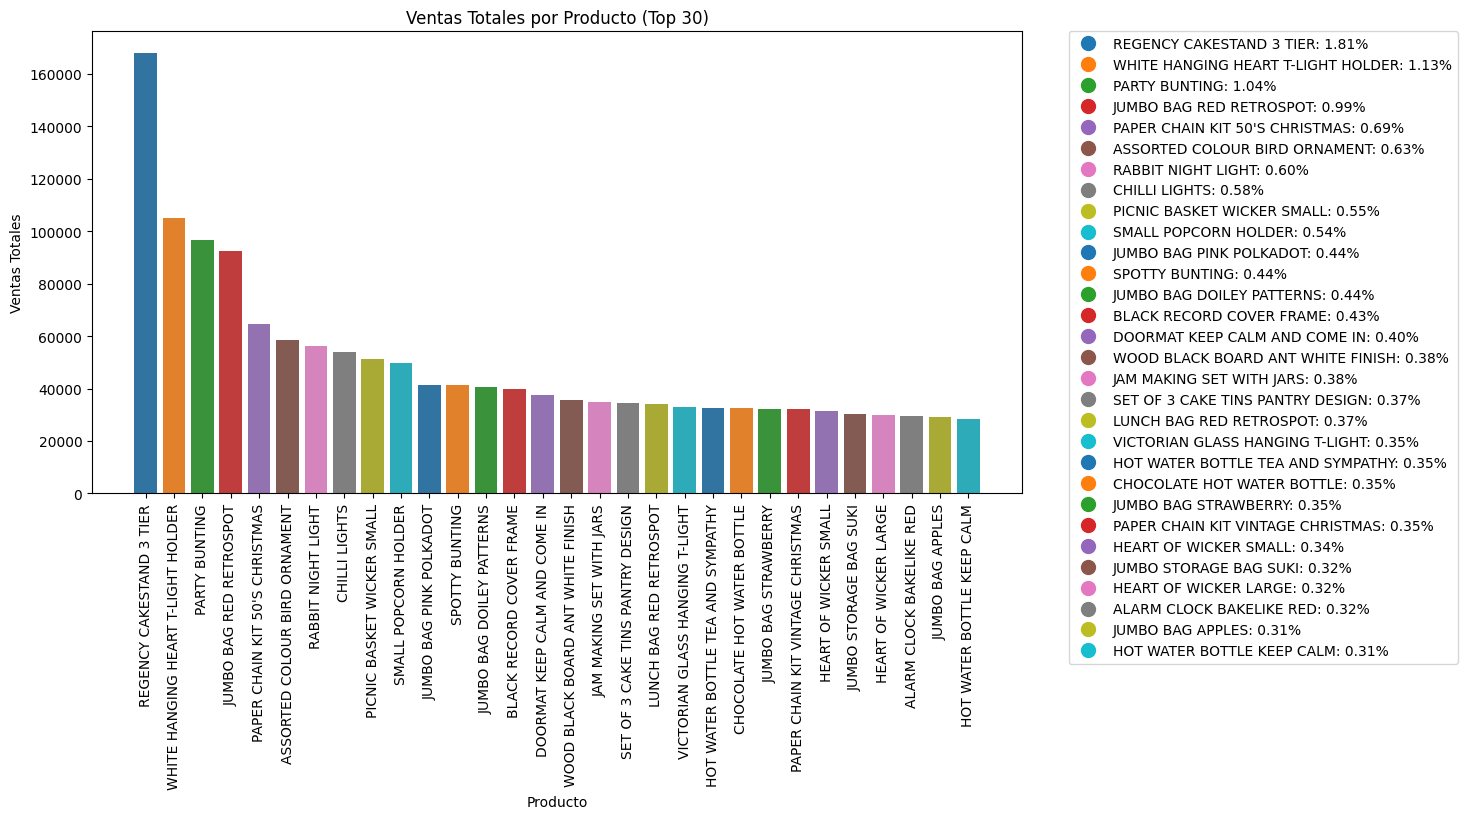

In [124]:
# Agrupa los datos por producto y suma las ventas totales
sales_by_country_product = df_com.groupby(['Description'])['TotalSales'].sum().reset_index()

# Calcula el porcentaje de ventas de cada producto respecto al total de ventas
total_sales = sales_by_country_product['TotalSales'].sum()
sales_by_country_product['Percentage'] = (sales_by_country_product['TotalSales'] / total_sales) * 100

# Ordena los datos por ventas totales en orden descendente
sales_by_country_product = sales_by_country_product.sort_values(by='TotalSales', ascending=False)

# Selecciona solo los 30 productos más vendidos
top_30_products = sales_by_country_product.head(30)

# Asigna un color diferente a cada producto
palette = sns.color_palette("tab10", len(top_30_products))

# Configura el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crea el gráfico de barras con Seaborn
barplot = sns.barplot(x='Description', y='TotalSales', data=top_30_products, palette=palette, hue='Description', dodge=False, legend=False)

# Añade etiquetas y título al gráfico
plt.xlabel('Producto')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Producto (Top 30)')
plt.xticks(rotation=90)  # Rota las etiquetas del eje x para que sean legibles

# Añade la leyenda con el porcentaje de ventas
patches = [plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=palette[i], 
            label="{:s}: {:.2f}%".format(top_30_products["Description"].iloc[i], 
            top_30_products["Percentage"].iloc[i]) )[0] for i in range(len(top_30_products))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Muestra el gráfico
plt.show()


Producto Principal: El producto "REGENCY CAKESTAND 3 TIER" lidera las ventas con un 1.81% del total, siendo significativamente más popular que los demás.

Diversidad en Ventas: La distribución de ventas es bastante variada, con una mezcla de productos decorativos, utilitarios y de regalo, como "WHITE HANGING HEART T-LIGHT HOLDER" y "PARTY BUNTING".

Rango de Ventas: Aunque el primer producto tiene una diferencia notable en ventas, el resto de los productos muestra una disminución más gradual y uniforme en la cantidad de ventas.

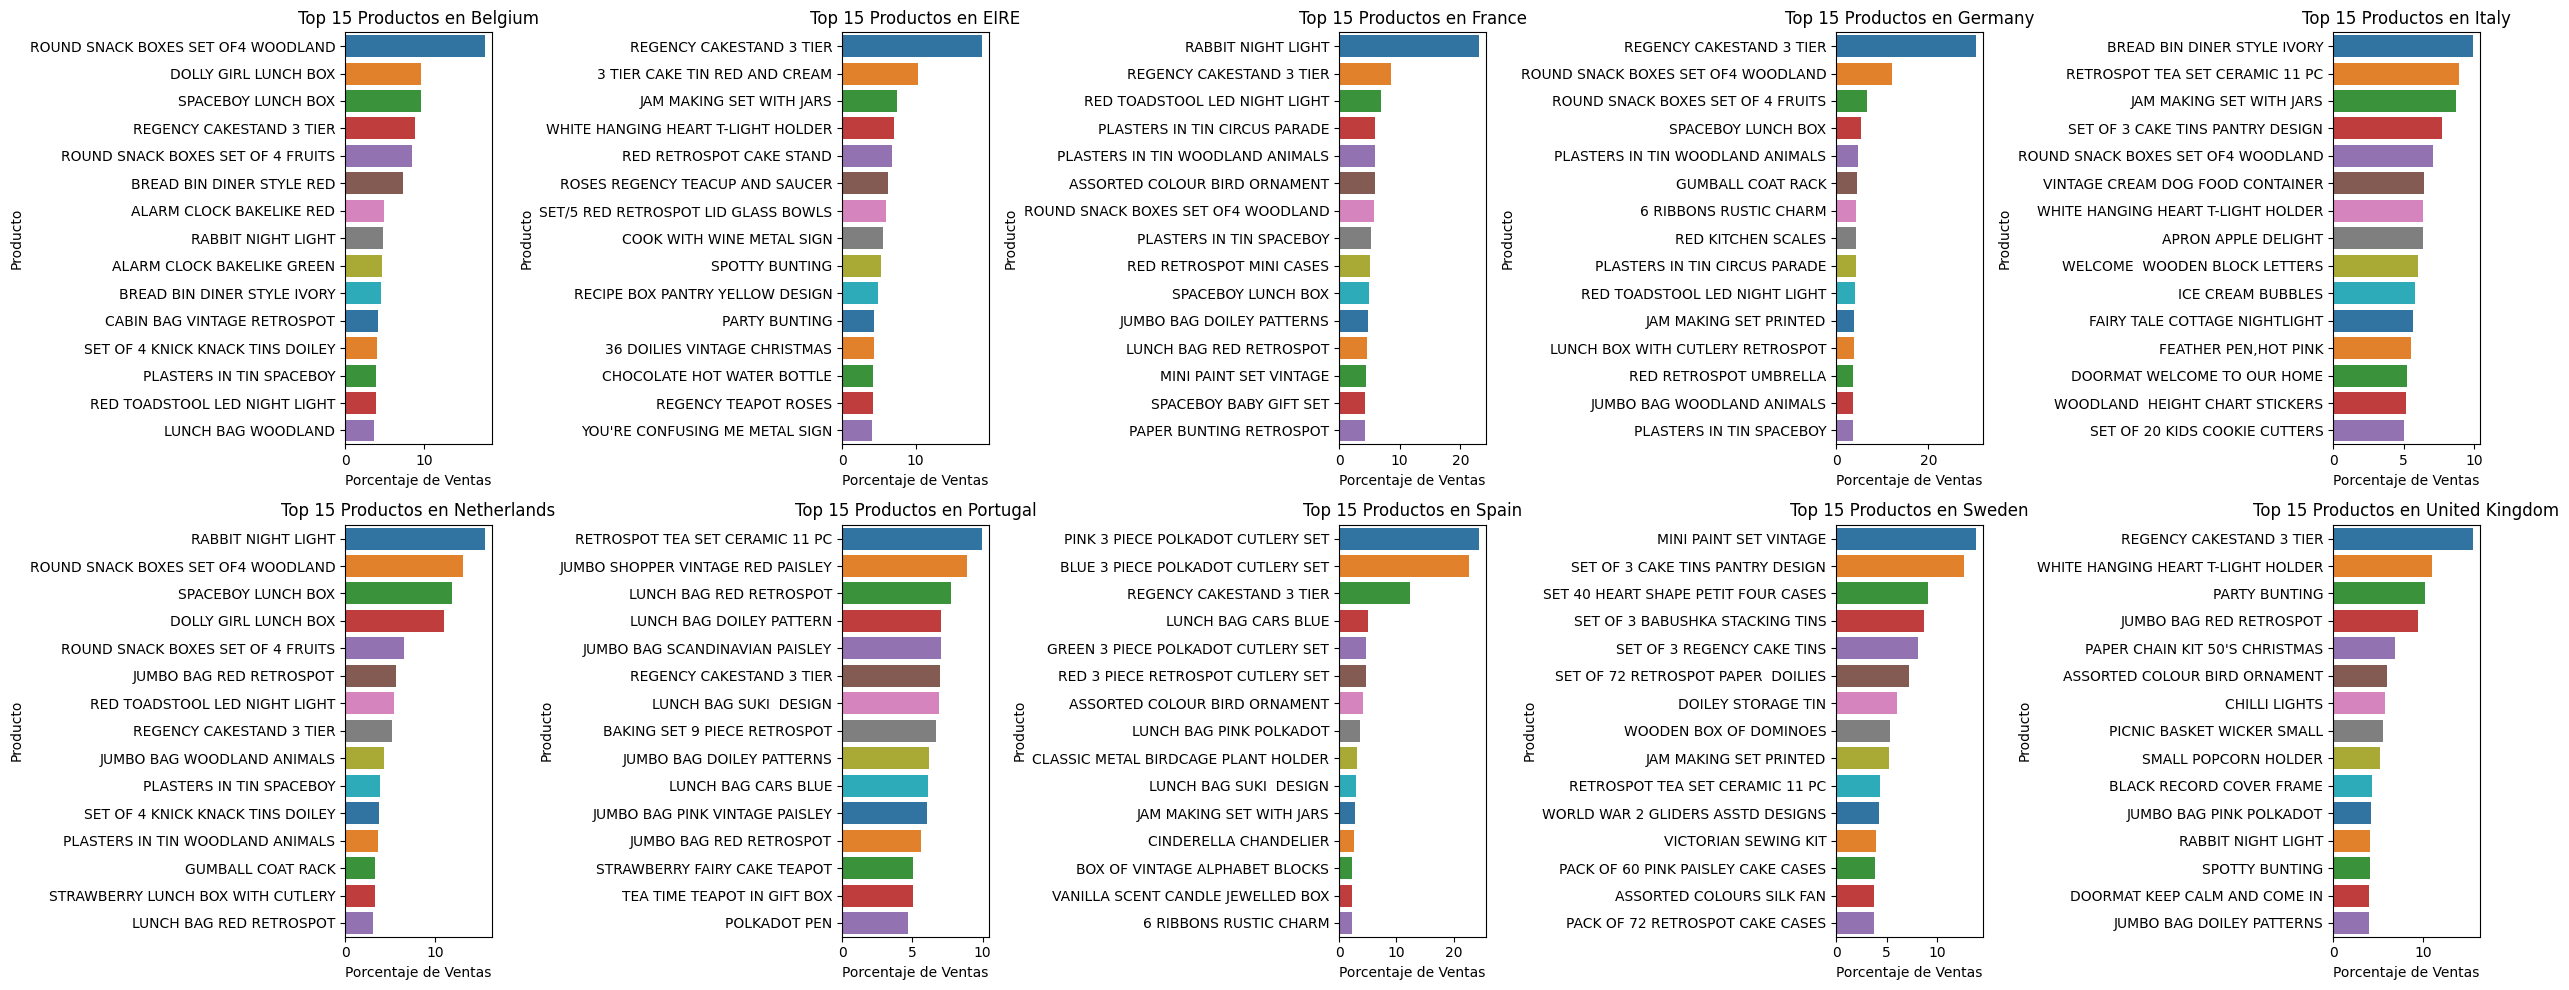

In [125]:
# Agrupa los datos por país y producto, y suma las ventas totales
sales_by_country_product = df_com.groupby(['Country', 'Description'])['TotalSales'].sum().reset_index()

# Lista de países únicos
countries = sales_by_country_product['Country'].unique()

# Número de países
num_countries = len(countries)

# Configura la cantidad de subplots por fila y columna
cols = 5  # Número de columnas
rows = math.ceil(num_countries / cols)  # Número de filas

# Crear figura
fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows))
axes = axes.flatten()

# Itera sobre cada país
for i, country in enumerate(countries):
    # Filtra los datos para el país actual
    country_data = sales_by_country_product[sales_by_country_product['Country'] == country]
    
    # Ordena los productos por ventas totales y selecciona los top 15
    top_products = country_data.nlargest(15, 'TotalSales')
    
    # Calcula el porcentaje de ventas de cada producto
    total_sales_country = top_products['TotalSales'].sum()
    top_products['Percentage'] = (top_products['TotalSales'] / total_sales_country) * 100
    
    # Crea el subplot para el país actual
    sns.barplot(x='Percentage', y='Description', data=top_products, hue='Description', dodge=False, palette="tab10", ax=axes[i], legend=False)
    
    # Añade etiquetas y título al gráfico
    axes[i].set_xlabel('Porcentaje de Ventas')
    axes[i].set_ylabel('Producto')
    axes[i].set_title(f'Top 15 Productos en {country}')
    axes[i].legend([], [], frameon=False)  # Elimina la leyenda de cada subplot

# Eliminar subplots vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Este gráfico presenta una visión general de los 15 productos más vendidos en varios países europeos. Sin embargo, es importante señalar que esta visualización, aunque informativa, no es completamente representativa para extraer conclusiones definitivas sobre las tendencias de ventas por producto en cada mercado.
Algunas observaciones preliminares:

Existe una variación significativa en los productos más populares entre países, lo que sugiere diferencias en las preferencias de los consumidores.

Algunos productos, como "ROUND SNACK BOXES SET OF4 WOODLAND" y "REGENCY CAKESTAND 3 TIER", aparecen con frecuencia en varios países, indicando una posible popularidad transnacional.
El Reino Unido parece tener un conjunto de productos más vendidos bastante diferente al de otros países, logico por su mayor volumne de ventas.

Sin embargo, para obtener conclusiones más sólidas, sería necesario realizar un análisis más profundo de cada país.


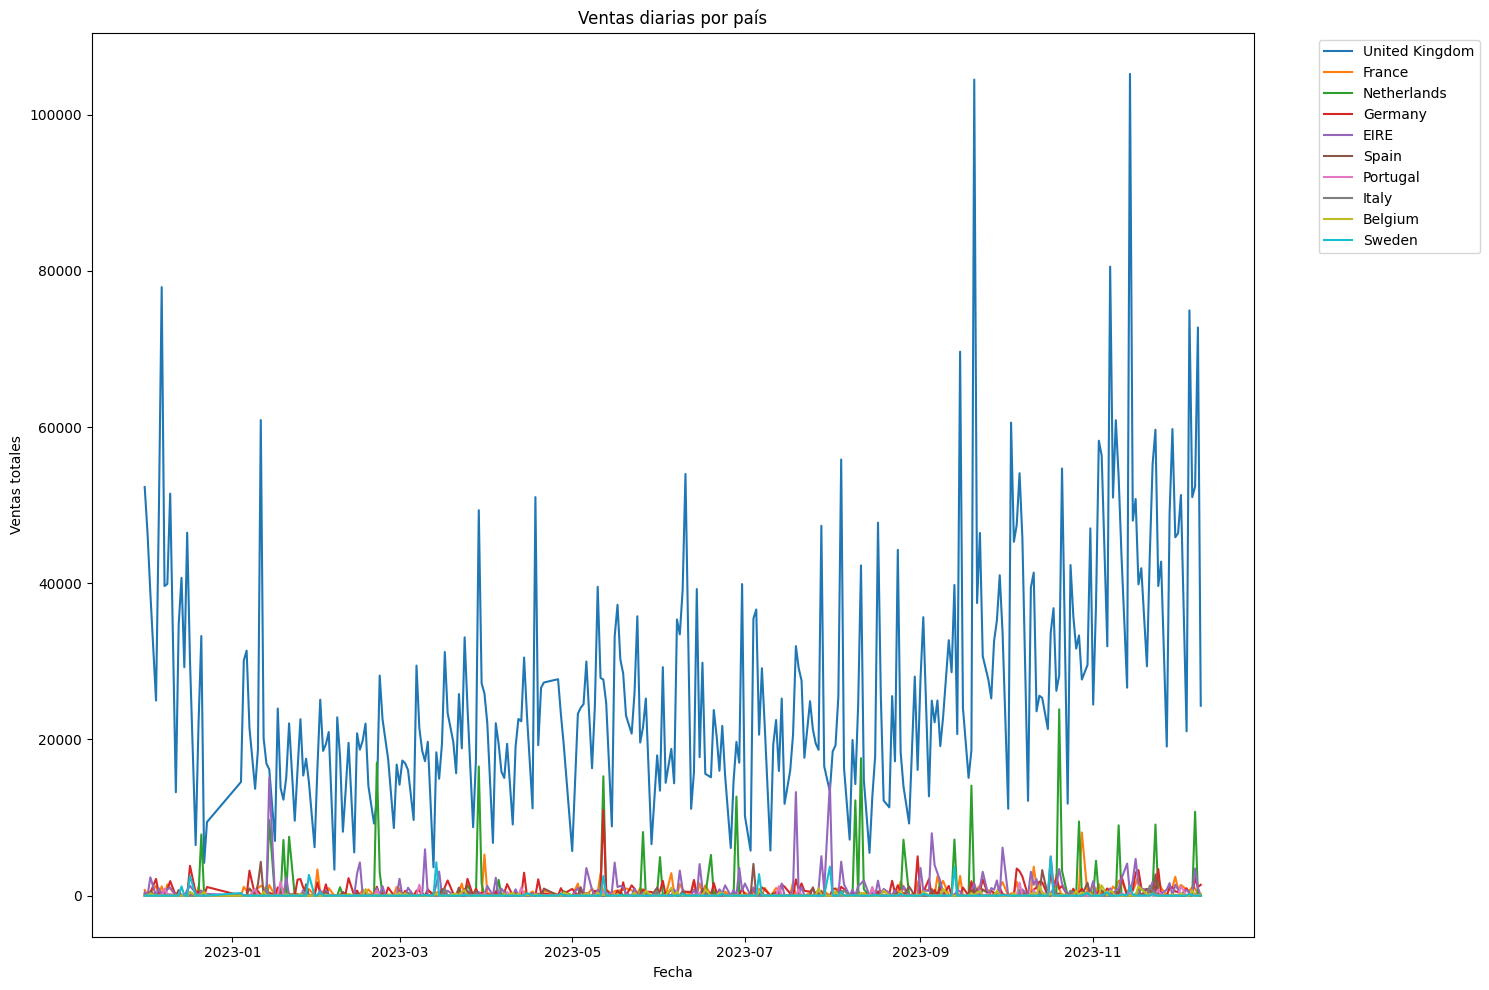

In [126]:
# Análisis de ventas por país
countries = ['United Kingdom', 'France', 'Netherlands', 'Germany', 'EIRE', 'Spain', 'Portugal', 'Italy', 'Belgium', 'Sweden']

# Crear un DataFrame con las ventas diarias por país
daily_sales = df_com.groupby([df_com.index, 'Country'])['TotalSales'].sum().unstack(fill_value=0)

# Configurar la paleta de colores
palette = sns.color_palette("tab10", len(countries))

# Gráfico de líneas para las ventas diarias por país
plt.figure(figsize=(15, 10))
for idx, country in enumerate(countries):
    if country in daily_sales.columns:
        sns.lineplot(data=daily_sales[country], label=country, color=palette[idx])
        
plt.title('Ventas diarias por país')
plt.xlabel('Fecha')
plt.ylabel('Ventas totales')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



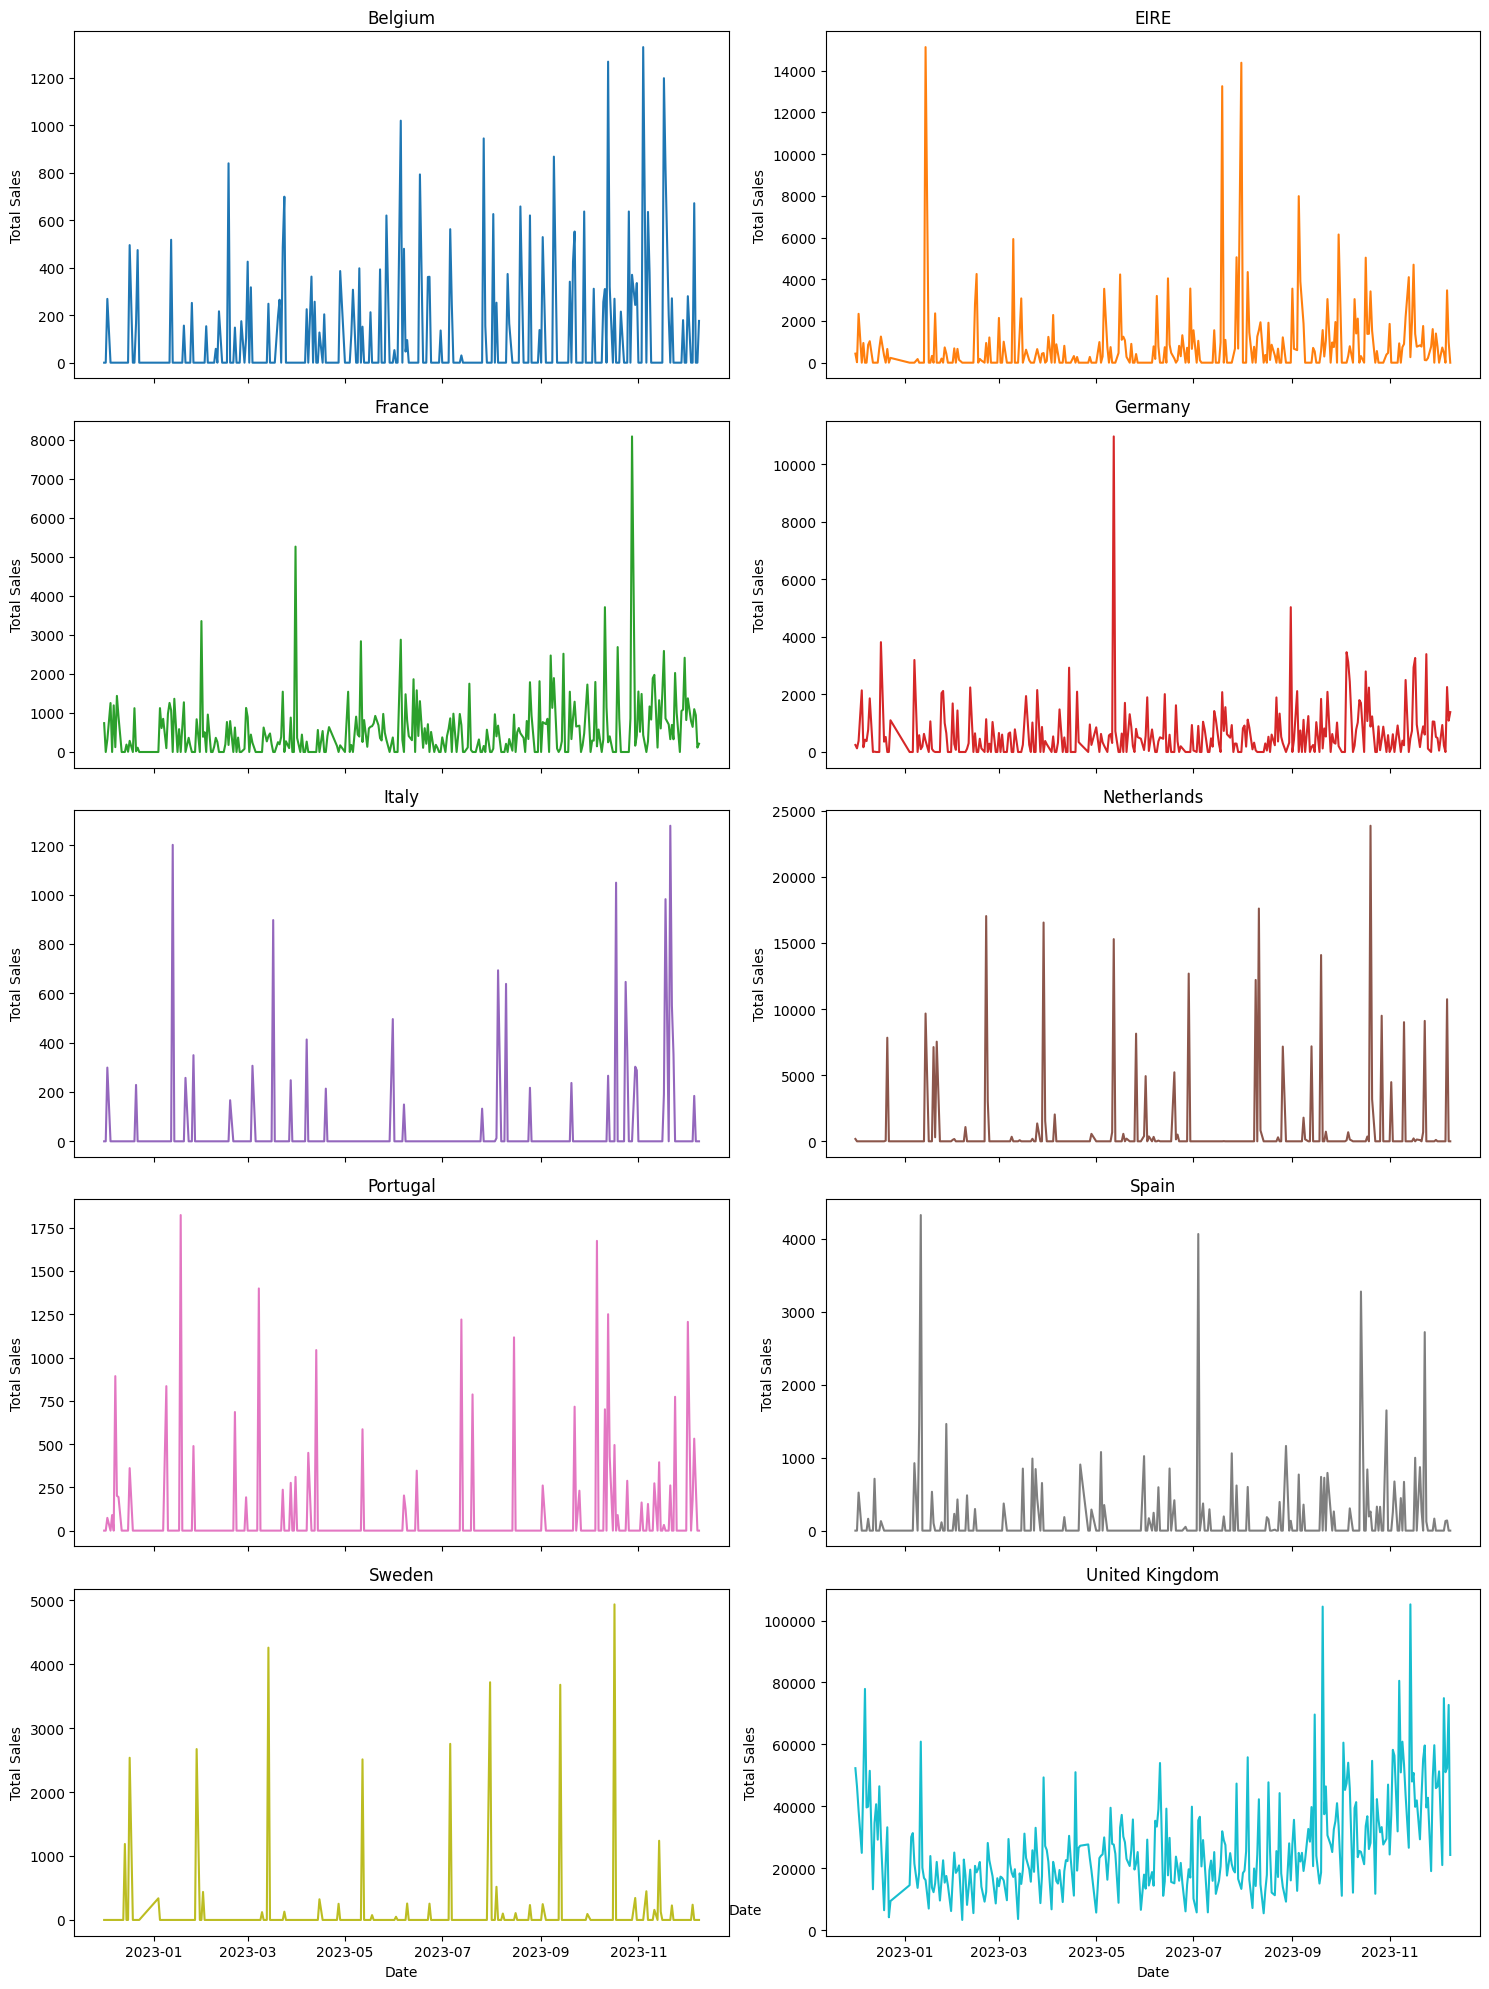

In [127]:


# Crear un DataFrame con las ventas diarias por país
daily_sales = df_com.groupby([df_com.index, 'Country'])['TotalSales'].sum().unstack(fill_value=0)

# Crear una figura y subgráficos
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=True)

# Aplanar la matriz de ejes para un fácil acceso
axes = axes.flatten()

# Iterar sobre las columnas y los ejes para graficar cada serie temporal
for i, (column, color) in enumerate(zip(daily_sales.columns, palette)):
    sns.lineplot(x=daily_sales.index, y=daily_sales[column], ax=axes[i], color=color)
    axes[i].set_title(column)
    axes[i].set_ylabel('Total Sales')

# Añadir una etiqueta común para el eje x
fig.text(0.5, 0.04, 'Date', ha='center')

plt.tight_layout()
plt.show()


United Kingdom: Este país muestra un volumen de ventas significativamente mayor y más constante en comparación con otros países. Las ventas presentan picos y valles frecuentes, con algunos picos muy pronunciados. Este comportamiento sugiere una actividad comercial robusta y dinámica, posiblemente con ciclos semanales donde los picos bajos corresponden a los domingos.

Otros países: La mayoría de los otros países presentan volúmenes de ventas mucho menores en comparación con el Reino Unido. Las ventas en estos países son más irregulares y presentan menos picos altos, lo que sugiere una actividad comercial menos constante.

EIRE y Netherlands: Estos países muestran algunos picos altos ocasionales, pero en general, sus ventas son más volátiles y menos predecibles que las del Reino Unido.

Germany y France: También muestran cierta volatilidad, con picos ocasionales, pero en menor escala que EIRE y Netherlands.

Portugal, Italy, Belgium, Spain y Sweden: Estos países presentan las ventas más bajas y más irregulares, con picos esporádicos.



## 1.2.1 Feature engineering

En el presente análisis, se ha optado por transformar la información de ventas en características más relevantes y manejables que faciliten la comprensión y la modelización de los datos. En lugar de analizar cada producto individualmente, lo cual podría generar una complejidad excesiva debido a la alta cantidad de referencias, se han creado las siguientes nuevas columnas:

- Ventas Diarias (DaySales): Esta métrica representa el total de ventas por día y por país. Al agregar las ventas de cada día, se obtiene una visión clara del desempeño general del negocio en diferentes mercados, lo que es crucial para la toma de decisiones estratégicas.

- Número de Productos Diferentes Vendidos (ProductsSales): Esta columna refleja la cantidad de productos únicos vendidos en cada día y país. Esta métrica es útil para entender la diversidad de la oferta que atrae a los consumidores y puede ayudar a identificar tendencias en la demanda de ciertos tipos de productos.

- Número de Facturas (InvoiceNumbers): Aunque se ha decidido eliminar la columna de descripción de productos, mantener el conteo de facturas permite analizar la actividad de compra. Esta métrica es indicativa de la frecuencia con la que los clientes están realizando compras, lo que puede ser un indicativo del comportamiento del consumidor y la efectividad de las campañas de marketing.

Además, se ha incorporado un enfoque para asegurar que todos los países tengan registros para cada día, incluyendo aquellos días sin datos. Para ello, se ha creado un rango de fechas que abarca desde el primer hasta el último día de datos, y se ha rellenado con ceros en los días donde no hubo actividad. Este tratamiento no solo proporciona una serie temporal completa, sino que también mejora la capacidad del modelo para predecir las ventas de los próximos 30 días y facilita el análisis de la autocorrelación en los datos.

La combinación de estas características y el manejo cuidadoso de los días sin datos proporciona un marco más sencillo y claro para el análisis, permitiendo un enfoque más efectivo en el modelado predictivo y la identificación de patrones de comportamiento en las ventas. La reducción de la dimensionalidad de los datos al eliminar variables menos relevantes mejora la interpretabilidad y eficiencia del modelo, facilitando la identificación de las variables más significativas que impactan en las ventas.

In [128]:

daily_sales = df_com.groupby(['Date', 'Country'])['TotalSales'].sum().reset_index()
daily_sales.rename(columns={'TotalSales': 'DaySales'}, inplace=True)

# Calcular el número de productos únicas diarias por país
product_number = df_com.groupby(['Date', 'Country'])['StockCode'].nunique().reset_index()
product_number.rename(columns={'StockCode': 'ProductsSales'}, inplace=True)

# Calcular el tickets de venta diarios por país
sales_number = df_com.groupby(['Date', 'Country'])['InvoiceNo'].nunique().reset_index()
sales_number.rename(columns={'InvoiceNo': 'InvoiceNumbers'}, inplace=True)

# Combinar ambos resultados en un único DataFrame
result = pd.merge(daily_sales, product_number, on=['Date', 'Country'])
df_com = pd.merge(result, sales_number, on=['Date', 'Country'])


In [129]:
# Establecemos la columna 'Date' como índice del DataFrame df_com.
df_com.set_index("Date", inplace=True)

In [130]:
# Agrupamos el DataFrame df_com por 'Date' y 'Country', 
df_grouped = df_com.groupby(['Date', 'Country']).sum()

# Crear un rango de fechas
date_range = pd.date_range(start=df_com.index.min(), end=df_com.index.max())

# Obtener la lista única de países
countries = df_com['Country'].unique()

# Crear un MultiIndex con todas las combinaciones de fechas y países
multi_index = pd.MultiIndex.from_product([date_range, countries], names=['Date', 'Country'])

# Reindexar el DataFrame agrupado con el MultiIndex
df_com = df_grouped.reindex(multi_index, fill_value=0).reset_index()

In [131]:
# Establecemos la columna 'Date' como índice del DataFrame df_com.
df_com.set_index("Date", inplace=True)

In [132]:
df_com

Country  DaySales  ProductsSales  InvoiceNumbers
Date                                                               
2022-12-01            EIRE    433.08             15               1
2022-12-01          France    738.90             14               1
2022-12-01         Germany    243.48             14               1
2022-12-01     Netherlands    177.60              1               1
2022-12-01  United Kingdom  52323.12           1060             119
...                    ...       ...            ...             ...
2023-12-09         Belgium    176.00             13               1
2023-12-09           Italy      0.00              0               0
2023-12-09        Portugal      0.00              0               0
2023-12-09           Spain      0.00              0               0
2023-12-09          Sweden      0.00              0               0

[3740 rows x 4 columns]

Conclusión y pasos siguientes:

Dado que el Reino Unido es el país más representativo en términos de volumen de ventas y muestra un comportamiento distintivo, se continuará con un análisis más detallado de sus datos. Este análisis incluirá la creación de modelos predictivos utilizando SARIMAX, Prophet y XGBoost para capturar y predecir mejor las tendencias y patrones en las ventas diarias del Reino Unido. Visto que los datos de los demas paises son un porcentaje muy bajo del total y que hay pocos datos, me centrare en UK y buscare el algortimo que mejor resultado rmse y r2.

## 1.3 Analisis UK

In [38]:
df_uk = df_com[df_com["Country"] == "United Kingdom"]

In [39]:
df_uk

Country  DaySales  ProductsSales  InvoiceNumbers
Date                                                               
2022-12-01  United Kingdom  52323.12           1060             119
2022-12-02  United Kingdom  46407.64            749             137
2022-12-03  United Kingdom  38721.98            855              54
2022-12-04  United Kingdom      0.00              0               0
2022-12-05  United Kingdom  24979.59            883              79
...                    ...       ...            ...             ...
2023-12-05  United Kingdom  74928.06           1468             113
2023-12-06  United Kingdom  51020.46           1154             102
2023-12-07  United Kingdom  52394.04            802              91
2023-12-08  United Kingdom  72747.00           1371             113
2023-12-09  United Kingdom  24308.93            767              35

[374 rows x 4 columns]

In [40]:
px.line(df_uk["DaySales"])

Como se puede observar, hay una tendencia en el tiempo y eso sugiere que los datos no son estacionarios. Sin embargo, para asegurar la estacionariedad de la serie, utilizamos el test Dickey-Fuller.

# 2. Desarrollo de Métodos

## 2.1 Modelo SARIMAX.


Vamos a usar modelo ARIMA-SARIMAX, los parámetros  p,d, y q representan las componentes autorregresivas, de diferenciación y de media móvil, respectivamente. P, D, y Q son las mismas componentes para la parte estacional del modelo y m el número de períodos en cada temporada.

- p - es el orden (número de lags temporales) de la parte autorregresiva del modelo.

- d - es el grado de diferenciación (el número de veces que se han restado los valores consecutivos de la serie).

- q - es el tamaño de la media móvil del modelo.

- P - es el orden (número de lags temporales) de la parte estacional del modelo.

- D - es el grado de diferenciación de la parte estacional del modelo.

- Q - es el tamaño de la media móvil de la parte estacional del modelo.

- m - indica al número de períodos en cada temporada.

Cuando los términos P, D, Q, y m son cero y no se incluyen variables exógenas, el modelo SARIMAX es equivalente a un ARIMA.

### 2.1.1 Prueba Dickey-Fuller

La Prueba de Dickey-Fuller busca determinar la existencia o no de raíces unitarias en una serie de tiempo. La hipótesis nula de esta prueba es que existe una raíz unitaria en la serie.1​

- **Hipótesis nula (H₀)**: La serie temporal tiene una raíz unitaria, lo que implica que la serie no es estacionaria.
- **Hipótesis alternativa (H₁)**: La serie temporal no tiene una raíz unitaria, lo que implica que la serie es estacionaria.


$
H_0: \phi = 1
$

$
H_1: \phi < 1
$

In [41]:
print('Test estacionariedad serie original de ventas diarias en UK')
print('-------------------------------------')
adfuller_result = adfuller(df_uk["DaySales"])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')


Test estacionariedad serie original de ventas diarias en UK
-------------------------------------
ADF Statistic: -2.0948080446255957, p-value: 0.24660743150519876


In [42]:
df_uk.loc[:, 'diff_DaySales'] = df_uk['DaySales'] - df_uk['DaySales'].shift(1)
df_uk.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19160\797593568.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Country  DaySales  ProductsSales  InvoiceNumbers  \
Date                                                                  
2022-12-01  United Kingdom  52323.12           1060             119   
2022-12-02  United Kingdom  46407.64            749             137   
2022-12-03  United Kingdom  38721.98            855              54   
2022-12-04  United Kingdom      0.00              0               0   
2022-12-05  United Kingdom  24979.59            883              79   

            diff_DaySales  
Date                       
2022-12-01            NaN  
2022-12-02       -5915.48  
2022-12-03       -7685.66  
2022-12-04      -38721.98  
2022-12-05       24979.59

In [43]:
print('Test estacionariedad serie diff 1 de ventas diarias en UK')
print('-------------------------------------')
adfuller_result = adfuller(df_uk["diff_DaySales"].dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

Test estacionariedad serie diff 1 de ventas diarias en UK
-------------------------------------
ADF Statistic: -8.011051321735943, p-value: 2.200922799414674e-12


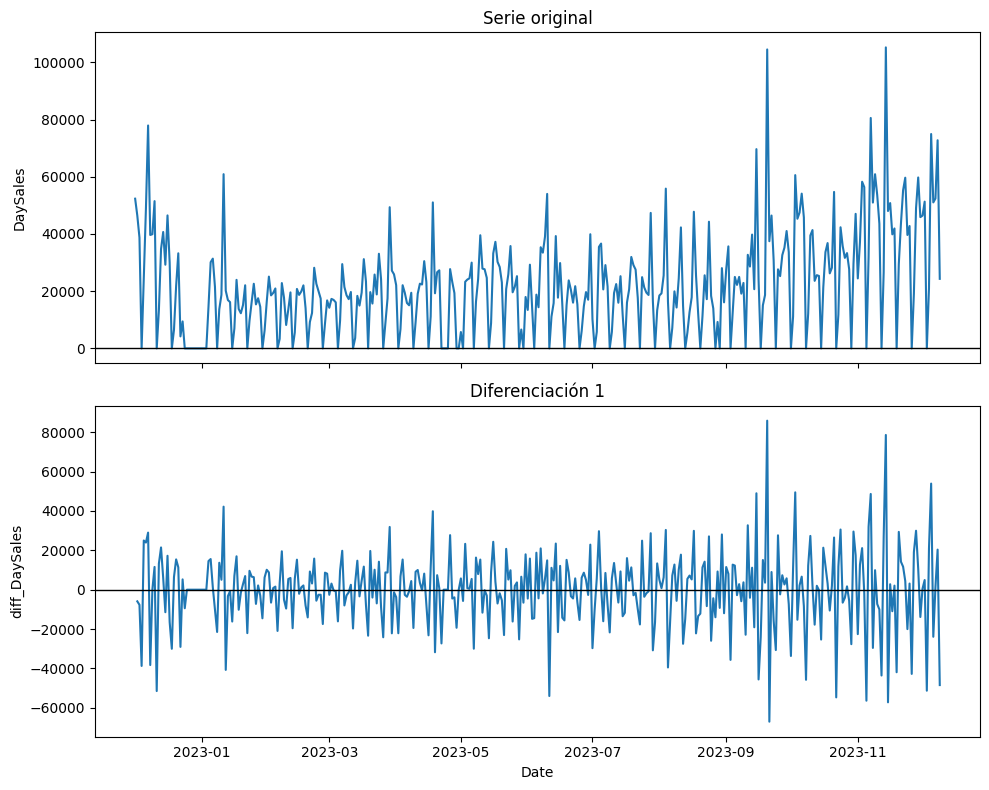

In [44]:

# Crear la figura y los ejes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# Gráfico de la serie original
sns.lineplot(data=df_uk, x=df_uk.index, y="DaySales", ax=axs[0])
axs[0].set_title('Serie original')
axs[0].axhline(0, color='black', linewidth=1)  # Añadir línea en y=0
axs[0].grid(False)  # Quitar cuadrícula

# Gráfico de la serie diferenciada
sns.lineplot(data=df_uk, x=df_uk.index, y="diff_DaySales", ax=axs[1])
axs[1].set_title('Diferenciación 1')
axs[1].axhline(0, color='black', linewidth=1)  # Añadir línea en y=0
axs[1].grid(False)  # Quitar cuadrícula

# Ajustar el diseño
plt.tight_layout()
plt.show()

El p-value obtenido tras la primera diferenciación es estadísticamente significativo para rechazar H0 por ser menor de 0.05. Por lo tanto, la selección más adecuada para el parámetro ARIMA  d - es 0.

### 2.1.2 Análisis de autocorrelación.

El gráfico de la función de autocorrelación ( Autocorrelation Function ACF) y la función de autocorrelación parcial (Partial Autocorrelation Function (PACF)) de la serie temporal proporciona información útil sobre los posibles valores adecuados de p y q. La ACF ayuda a identificar el valor de q (retardos en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de  p(retardos en la parte autorregresiva).


Si el análisis de estacionariedad indica que es necesario diferenciar las series, los análisis posteriores deben realizarse utilizando la serie diferenciada, ya que esta es la forma a la forma en que el modelo ARIMA interpreta la serie.

**Función de autocorrelación (ACF)**

La ACF calcula la correlación entre una serie temporal y sus valores retardados (lags). En el contexto de la modelización ARIMA, una caída brusca de la ACF después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. El retardo en el que cae la ACF proporciona una estimación del valor de  q
.Si el ACF muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere la presencia de estacionalidad y requiere la consideración de órdenes estacionales además de órdenes no estacionales.

**Función de autocorrelación parcial (PACF)**

La PACF mide la correlación entre un valor retardado (lag) y el valor actual de la serie temporal, teniendo en cuenta el efecto de los retardos intermedios. En el contexto de la modelización ARIMA, si la PACF se corta bruscamente después de un determinado retardo, mientras que los valores restantes están dentro del intervalo de confianza, sugiere un modelo AR de ese orden. El desfase en el que se corta el PACF da una idea del valor de  p.


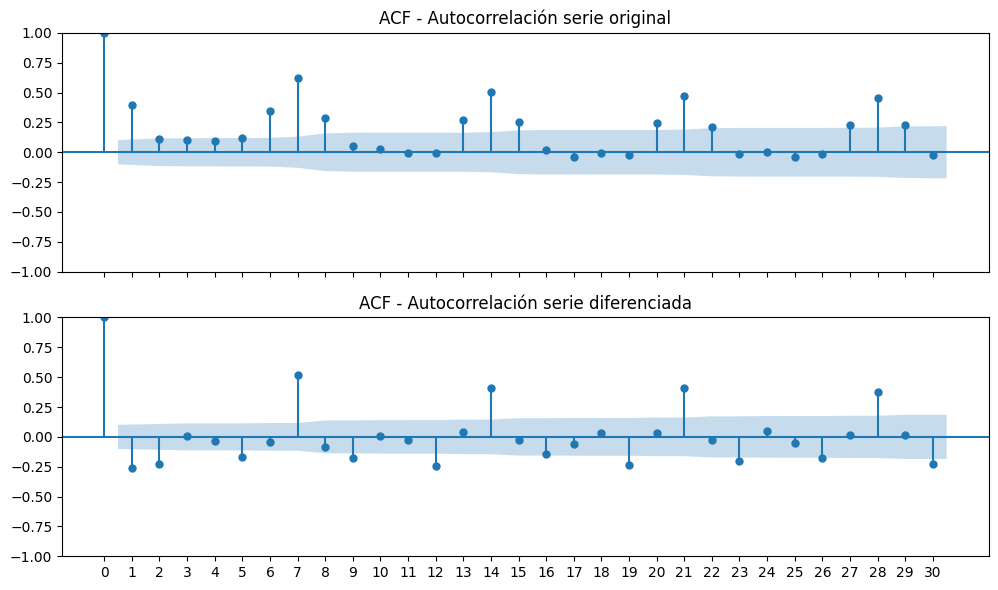

In [45]:
# Crear la figura y los ejes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Gráfico de autocorrelación para la serie original
plot_acf(df_uk["DaySales"], ax=axs[0], lags=30, alpha=0.05)
axs[0].set_title('ACF - Autocorrelación serie original')
axs[0].grid(False)  # Quitar cuadrícula


# Gráfico de autocorrelación para la serie diferenciada
plot_acf(df_uk["diff_DaySales"].dropna(), ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('ACF - Autocorrelación serie diferenciada')
axs[1].grid(False)  # Quitar cuadrícula

# Ajustar las etiquetas del eje x para que se muestren todas
num_lags = 30
axs[1].set_xticks(range(num_lags + 1))
axs[1].set_xticklabels(range(num_lags + 1))

# Ajustar el diseño
plt.tight_layout()
plt.show()

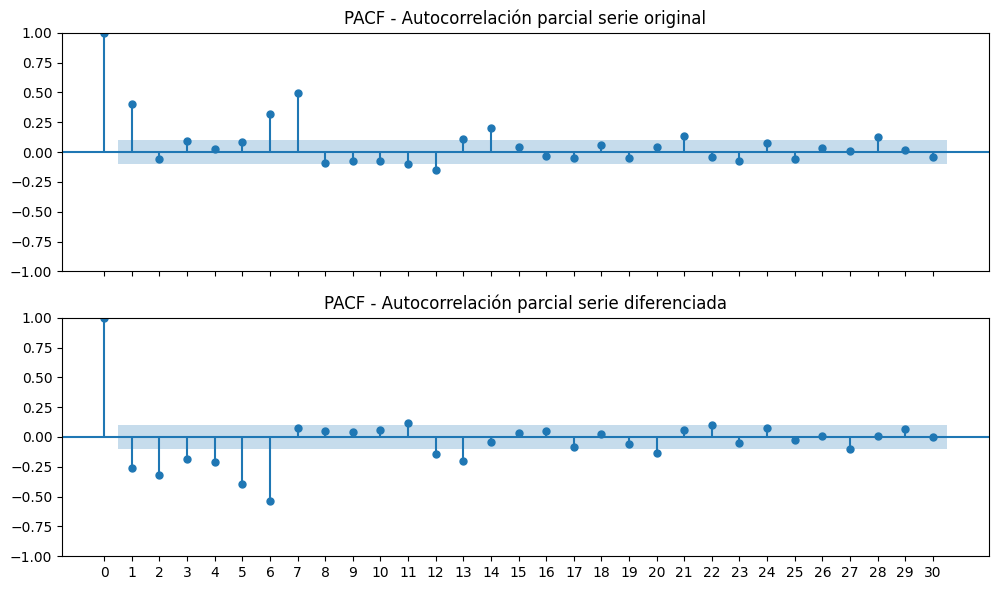

In [46]:
# Crear la figura y los ejes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Gráfico de autocorrelación para la serie original
plot_pacf(df_uk["DaySales"], ax=axs[0], lags=30, alpha=0.05)
axs[0].set_title('PACF - Autocorrelación parcial serie original')
axs[0].grid(False)  # Quitar cuadrícula


# Gráfico de autocorrelación para la serie diferenciada
plot_pacf(df_uk["diff_DaySales"].dropna(), ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('PACF - Autocorrelación parcial serie diferenciada')
axs[1].grid(False)  # Quitar cuadrícula

# Ajustar las etiquetas del eje x para que se muestren todas
num_lags = 30
axs[1].set_xticks(range(num_lags + 1))
axs[1].set_xticklabels(range(num_lags + 1))

# Ajustar el diseño
plt.tight_layout()
plt.show()

Después de diferenciar la serie, la gráfica de ACF muestra que la mayoría de los coeficientes de autocorrelación se encuentran dentro de los límites de confianza, la serie diferenciada es estacionaria, como hemos comprobado anteriormente con el test de Dickey_Fuller.

En la gráfica de PACF de la serie diferenciada, se observa un comportamiento más controlado con algunos rezagos significativos en los primeros lags, lo que sugiere que el componente AR se ha manejado adecuadamente y la serie es estacionaria después de la diferenciación.

- Valor de 𝑝 (orden del componente AR):

En la PACF de la serie diferenciada, se observa que el primer rezago es significativo, y hay algunos otros rezagos menores que también son significativos. Esto sugiere un valor de 𝑝 pequeño,posiblemente **𝑝 = 1 o 𝑝 = 2**.

- Valor de 𝑞 (orden del componente MA):

En la ACF de la serie diferenciada, se observa que hay algunos rezagos iniciales significativos y luego la mayoría de los valores están dentro de los límites de confianza. Esto sugiere un valor de 
𝑞 pequeño, posiblemente **𝑞 = 1 o 𝑞 = 2**.

Aunque el análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) sugiere posibles valores para los parámetros 𝑝 y 𝑞 del modelo ARIMA, como ARIMA(1, 1, 1) o ARIMA(1, 1, 2), voy a utilizar el modelo autoARIMA para determinar los mejores parámetros de manera más precisa y robusta.

### 2.1.3 Descomposición de la serie temporal: modelo aditivo o multiplicativo

Para determinar si una descomposición multiplicativa o aditiva es más adecuada para tu serie temporal, debemos observar la naturaleza de los componentes de tendencia y estacionalidad en relación con el nivel de la serie.

Observaciones de la Serie Temporal:

- Variabilidad Estacional: La amplitud de las fluctuaciones estacionales parece aumentar con el nivel de la serie, especialmente visible en los primeros meses de 2023 y hacia el final del año. Las ventas diarias muestran picos que varían significativamente en magnitud.
- Tendencia y Nivel: Hay períodos con tendencias ascendentes y descendentes claras, con niveles de ventas que parecen variar significativamente.


Dada la observación de que la amplitud de las fluctuaciones estacionales parece aumentar con el nivel de la serie, la descomposición multiplicativa es la más adecuada para tu serie temporal. Este tipo de descomposición modelará mejor las variaciones estacionales y de tendencia que dependen proporcionalmente del nivel de la serie.

La descomposicsion multiplicativa no puede trabajar con valores de 0 o negativos y como mi serie tiene valores 0, asi que comprobaremos el modelo aditivo.

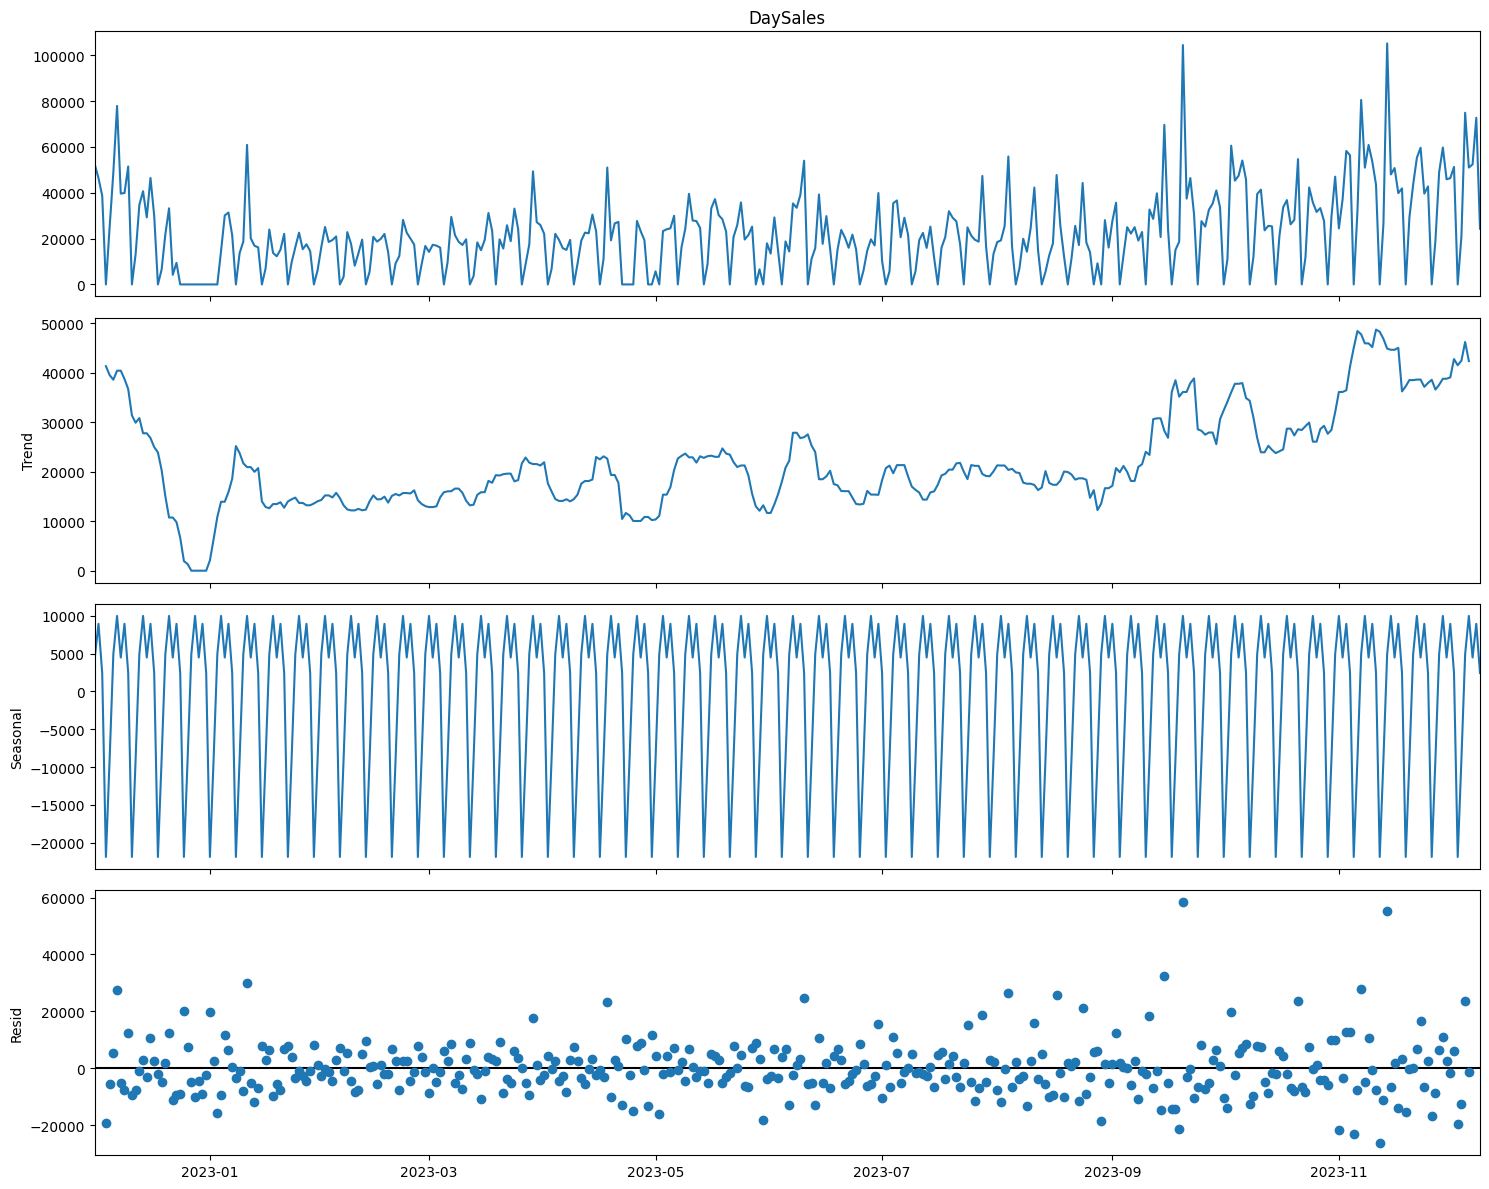

In [47]:
result_2 = seasonal_decompose(df_uk['DaySales'], model='additive', period=7)
result_2.plot()
plt.show()

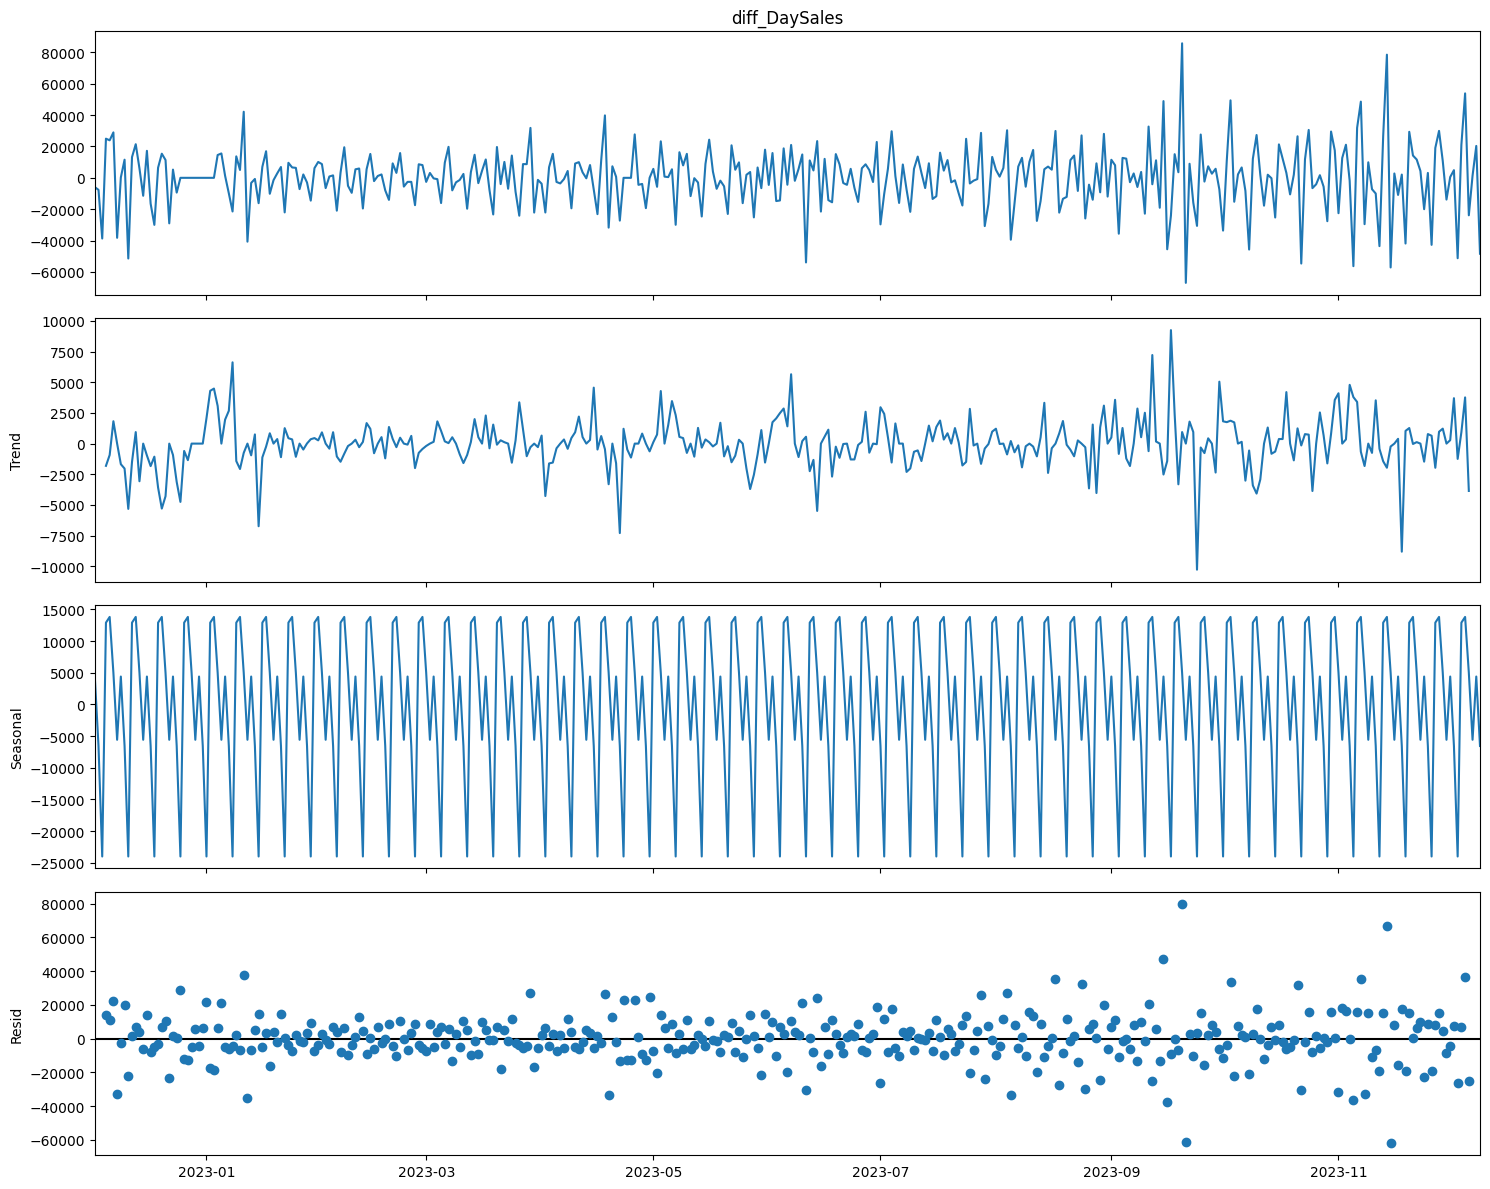

In [48]:
result_2 = seasonal_decompose(df_uk['diff_DaySales'].dropna(), model='additive', period=7)
result_2.plot()
plt.show()

En este caso el error esta centrado en 0 , pero la varianza no es 1, entonces necesitamos usar el modelo multiplicativo, primero voy a probar a meter 1 en los valores 0 o tranformar la serie a logaritmica.

### 2.1.4 Auto ARIMA

In [49]:
auto_arima = auto_arima(df_uk['DaySales'].dropna(),
                    start_P=0,
                    start_q=0,
                    max_p=20,
                    max_q=20,
                    d=1,
                    m=7,
                    seasonal=True,
                    D=0,
                    max_d = 20,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=8286.340, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8424.694, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8283.776, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8202.315, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8422.701, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8289.695, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8135.503, Time=0.56 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8184.554, Time=0.34 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=8171.806, Time=0.64 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8171.674, Time=0.96 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8222.005, Time=0.23 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=8200.208, Time=0.17 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=8172.036, Time=0.94 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=8290.108, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  374
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4031.251
Date:                           Wed, 24 Jul 2024   AIC                           8070.502
Time:                                   13:33:01   BIC                           8086.188
Sample:                               12-01-2022   HQIC                          8076.731
                                    - 12-09-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8313      0.028    -30.180      0.000      -0.885      -0.777
ar.S.L7        0.9928      0.005    199.946      0.000       0.983       1.002
ma.S.L7       -0.8791      0.026    -33.211      0.000      -0.931      -0.827
sigma2      1.386e+08   3.16e-11   4.38e+18      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               786.32
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                             1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+33. Standard errors may be unstable.
"""

In [50]:
# Aplicamos los parámetros obtenidos en el mejor modelo al SARIMAX

model_auto = SARIMAX(df_uk['DaySales'],order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False)
results_auto_arima = model_auto.fit()
print(results_auto_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          DaySales   No. Observations:                  374
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3979.894
Date:                           Wed, 24 Jul 2024   AIC                           7967.789
Time:                                   13:33:01   BIC                           7983.377
Sample:                               12-01-2022   HQIC                          7973.985
                                    - 12-09-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7055      0.073     -9.656      0.000      -0.849      -0.562
ar.S.L7        1.0043      0.036     27.813

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [51]:
df_uk

Country  DaySales  ProductsSales  InvoiceNumbers  \
Date                                                                  
2022-12-01  United Kingdom  52323.12           1060             119   
2022-12-02  United Kingdom  46407.64            749             137   
2022-12-03  United Kingdom  38721.98            855              54   
2022-12-04  United Kingdom      0.00              0               0   
2022-12-05  United Kingdom  24979.59            883              79   
...                    ...       ...            ...             ...   
2023-12-05  United Kingdom  74928.06           1468             113   
2023-12-06  United Kingdom  51020.46           1154             102   
2023-12-07  United Kingdom  52394.04            802              91   
2023-12-08  United Kingdom  72747.00           1371             113   
2023-12-09  United Kingdom  24308.93            767              35   

            diff_DaySales  
Date                       
2022-12-01            NaN  
2022-12-02       -5915.48  
2022-12-03       -7685.66  
2022-12-04      -38721.98  
2022-12-05       24979.59  
...                   ...  
2023-12-05       53888.80  
2023-12-06      -23907.60  
2023-12-07        1373.58  
2023-12-08       20352.96  
2023-12-09      -48438.07  

[374 rows x 5 columns]

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19160\3665957872.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



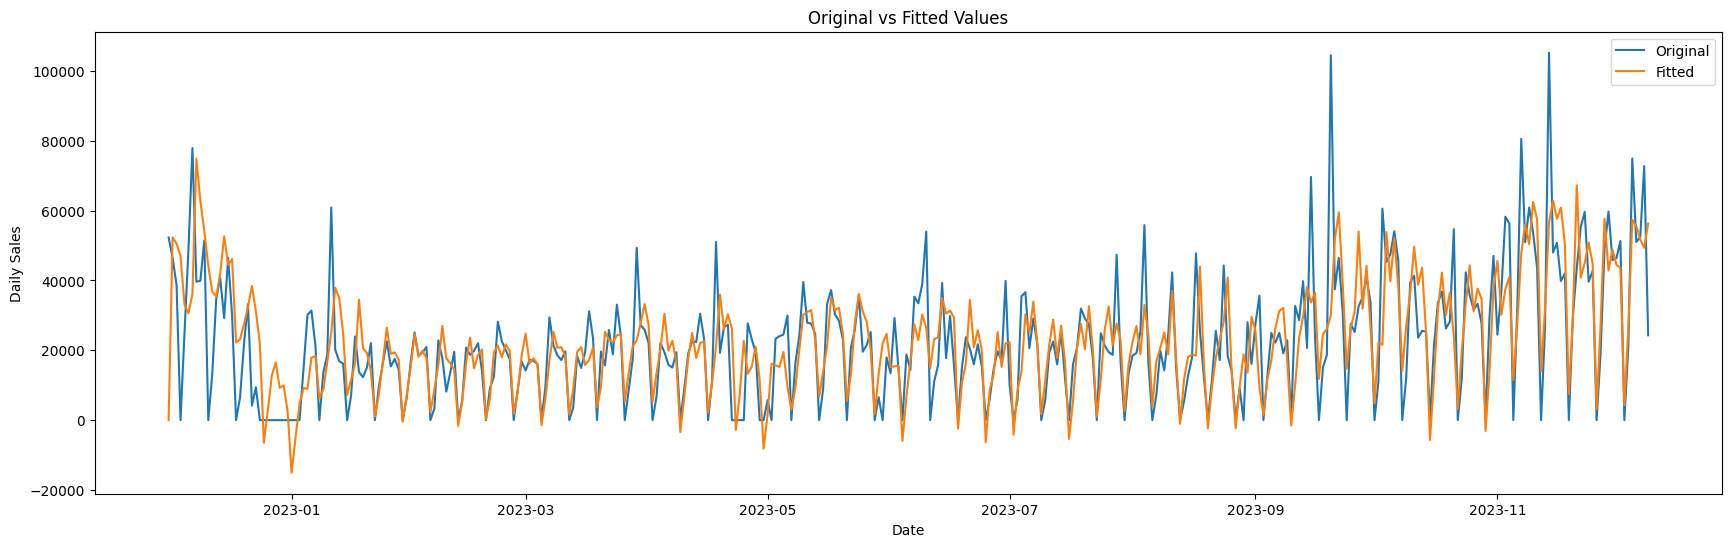

In [52]:
df_uk['Fitted'] = results_auto_arima.fittedvalues

# Graficar la serie original y las predicciones

plt.figure(figsize=(21, 6))
plt.plot(df_uk['DaySales'], label='Original')
plt.plot(df_uk['Fitted'], label='Fitted')
plt.legend()
plt.title('Original vs Fitted Values')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.show()

In [53]:
r2_score(y_pred = df_uk["Fitted"], y_true = df_uk['DaySales'])
root_mean_squared_error(y_pred = df_uk["Fitted"].dropna(), y_true = df_uk['DaySales'].dropna())

print(f'RMSE: {root_mean_squared_error(y_pred = df_uk["Fitted"].dropna(), y_true = df_uk['DaySales'].dropna())}')
print(f'R²: {r2_score(y_pred = df_uk["Fitted"], y_true = df_uk['DaySales'])}')

RMSE: 12799.768006264301
R²: 0.4747620929689451


Un RMSE de 12799 indica que en promedio, las predicciones del modelo se desvían de los valores reales por 12799 unidades. Este valor es considerablemente alto, sugiriendo que hay un error significativo en las predicciones.

El R² de 0.47 implica que aproximadamente el 47% de la variabilidad en las ventas diarias se puede explicar con el modelo SARIMAX. Aunque esto indica que el modelo tiene cierta capacidad predictiva, hay un 53% de la variabilidad que no está siendo capturada, lo cual sugiere que el modelo podría mejorarse.

### 2.1.5 Diagnostico SARIMAX.

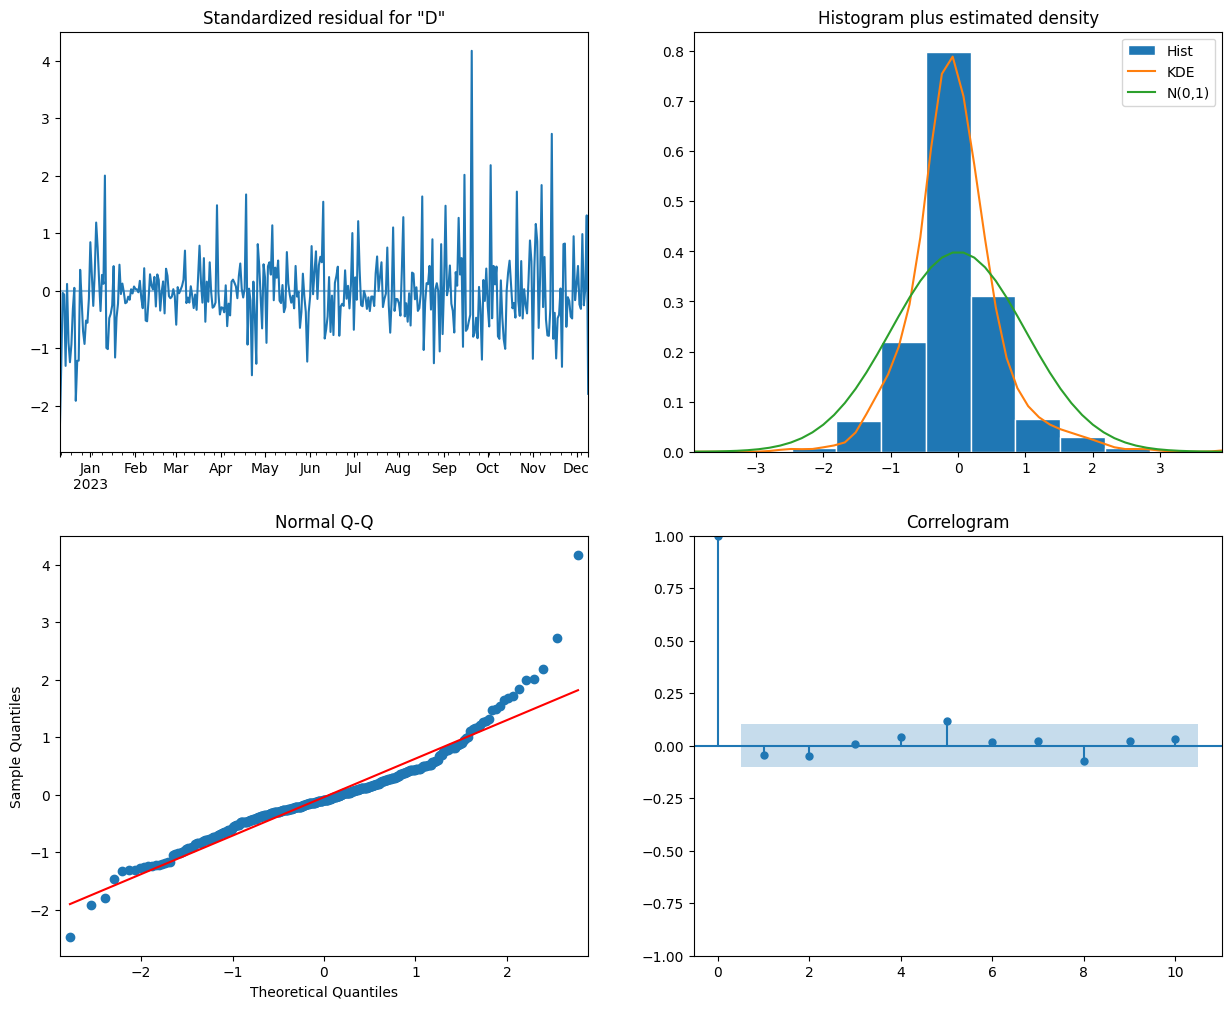

In [54]:
results_auto_arima.plot_diagnostics()
plt.show()


- Standardized Residual Plot: Esta gráfica muestra que los residuos estandarizados fluctúan alrededor de cero, lo cual es bueno. Sin embargo, se observan algunos picos fuera del rango esperado, lo que sugiere la presencia de valores atípicos o periodos donde el modelo no se ajusta bien a los datos.


- Histogram plus estimated density: El histograma muestra la distribución de los residuos estandarizados. Una buena señal es que parece aproximarse a una distribución normal, pero la asimetría y los picos indican que hay algunos residuos que no se ajustan a esta distribución, sugiriendo posibles mejoras en el modelo.


- Normal Q-Q Plot: Esta gráfica muestra que los puntos siguen aproximadamente la línea recta, lo cual indica que los residuos se distribuyen casi normalmente. No obstante, las desviaciones en los extremos sugieren que hay valores atípicos que el modelo no captura bien.


- Correlogram: El correlograma muestra que la mayoría de los residuos están dentro del intervalo de confianza, lo cual es positivo. Sin embargo, hay algunos rezagos que están fuera del rango, indicando autocorrelación residual que podría ser un indicio de que el modelo SARIMAX no ha capturado toda la estructura temporal de los datos.

### 2.1.6 Predicciones SARIMAX.

In [55]:
predicciones = results_auto_arima.predict(start = len(df_uk),
                        end=len(df_uk)+30,
                        typ='levels').rename('forecast_auto_arima')

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



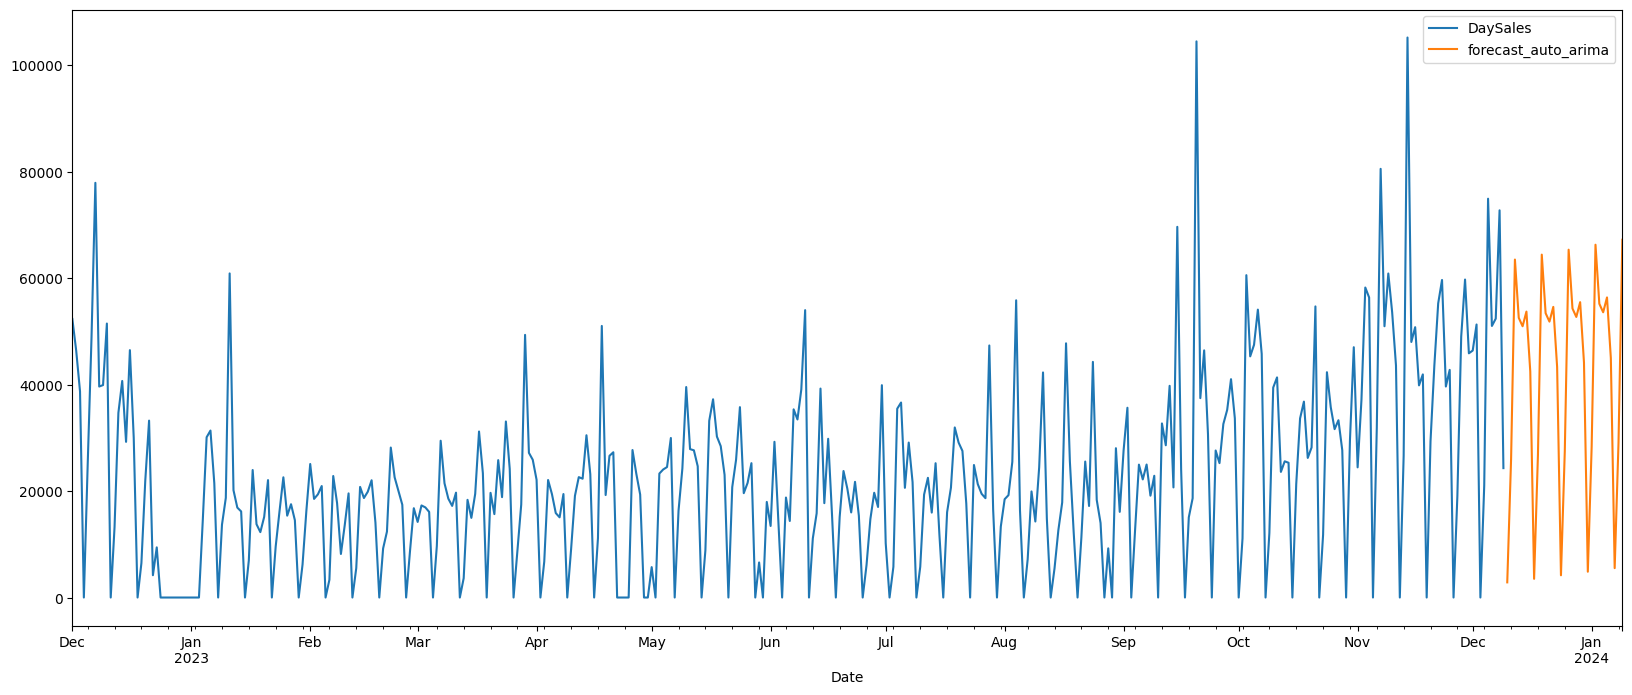

In [56]:
# Plot forecasts 
df_uk['DaySales'].plot(figsize=(20,8),legend=True)
predicciones.plot(legend=True)
plt.show()

La predicción para los próximos 30 días muestra una tendencia que sigue el patrón estacional observado en los datos históricos. Las ventas parecen mantener una estacionalidad semanal clara, con picos y valles similares a los datos anteriores. 

Patrones Estacionales: La predicción mantiene los patrones estacionales observados, lo cual es una buena señal de que el modelo ha capturado la estacionalidad de manera efectiva. 


Nivel de Ventas: Se espera que las ventas continúen con fluctuaciones diarias significativas, similar a los datos históricos. Esto indica que el modelo está proyectando la variabilidad en las ventas de manera consistente con lo observado.

Considerar otros enfoques como Prophet, podrían capturar mejor la complejidad de los datos.



## 2.2 Prophet

Prophet es un algoritmo / procedimiento de predicción de datos de series temporales basado en un modelo aditivo en el que se ajustan las tendencias no lineales para la estacionalidad anual, semanal y diaria, además de los efectos de días festivos. Prophet funciona mejor con series temporales que tienen efectos estacionales fuertes (ya sean semanales o mensuales) y una cantidad suficiente de datos históricos donde se representa esa estacionalidad. Prophet es robusto ante datos faltantes y cambios de tendencia, y tiende a manejar bien los valores atípicos. En este caso con los datos que tenemos este modelo puede funcionar bastante bien por su caracteristicas.

### 2.2.1 Preparación de datos:

Se renombra la columna 'DaySales' a 'y' y se establece la columna de fechas como 'ds'.
Se reinicia el índice del DataFrame.

In [57]:
# Seleccionamos la columna 'DaySales' de la dataframe df_uk y se la asignamos a uk_prophet
uk_prophet = df_uk[['DaySales']]

# Renombramos la columna 'DaySales' con el nombre 'y'
uk_prophet = uk_prophet.rename(columns={'DaySales': 'y'})

# Asignamos el índice de uk_prophet como nueva columna llamada 'ds'
uk_prophet['ds'] = uk_prophet.index

# Resetemos el índice de uk_prophet y mantenemos la información original (drop=False)
uk_prophet.reset_index(drop=True, inplace=False)

# Mostramos las primeras 2 filas de uk_prophet utilizando display
display(uk_prophet.head(2))

# Mostramos información detallada sobre la estructura de uk_prophet utilizando display
display(uk_prophet.info())



y         ds
Date                           
2022-12-01  52323.12 2022-12-01
2022-12-02  46407.64 2022-12-02

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       374 non-null    float64       
 1   ds      374 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.8 KB


None

### 2.2.2 Definición de días festivos personalizados:

Se crea un DataFrame con fechas específicas marcadas como 'close', incluyendo periodos de vacaciones y otros días especiales.

In [58]:
holidays_custom = pd.DataFrame({
    'holiday': 'close',
    'ds': pd.to_datetime(['2022-12-24','2022-12-25','2022-12-26',
                        '2022-12-27', '2022-12-28', '2022-12-29',
                        '2022-12-30', '2022-12-31', '2023-01-01',
                        '2023-01-02', '2023-01-02', '2023-01-03',
                        '2023-12-24','2023-12-25','2023-12-26',
                        '2023-12-27', '2023-12-28', '2023-12-29',
                        '2023-12-30', '2023-12-31', '2024-01-01',
                        '2024-01-02', '2024-01-02', '2024-01-03',
                        '2023-04-22', '2023-04-23',"2023-04-24",
                        "2023-04-25"]),
    'lower_window': 0,#siempre va con estos valores
    'upper_window': 1,
})

### 2.2.3 Configuración y entrenamiento del modelo Prophet:

Se inicializa el modelo Prophet con los días festivos personalizados.
Se configura el modo de estacionalidad como multiplicativo.
Se añaden los días festivos del Reino Unido.
Se ajusta el modelo a los datos de entrenamiento

In [59]:

# Creamos un objeto Prophet con los parámetros siguientes:
#   - `holidays`: el DataFrame de fechas festivas personalizadas que definimos anteriormente
#   - `seasonality_mode`: modo de seasonality, en este caso 'multiplicative'
#   - `weekly_seasonality`: indica si se debe incluir la temporada semanal en las predicciones
#   - `scaling`: método para escalar los datos, en este caso 'minmax' (min-max scaling)
m = Prophet(holidays=holidays_custom , seasonality_mode='multiplicative', weekly_seasonality=True, scaling="minmax")

# Agregamos las festividades del país seleccionado ('UK') al objeto Prophet
m.add_country_holidays(country_name='UK')

# Ajustamos el modelo Prophet a los datos de entrenamiento (uk_prophet)
m.fit(uk_prophet)


13:33:02 - cmdstanpy - INFO - Chain [1] start processing
13:33:02 - cmdstanpy - INFO - Chain [1] done processing


### 2.2.4 Generación de predicciones:

Se crea un DataFrame para predicciones futuras (30 días).
Se realizan predicciones utilizando el modelo entrenado.
Se reemplazan los valores negativos por 0 en las predicciones.

In [60]:
uk_future_df = m.make_future_dataframe(periods=30) # make an extra year
uk_forecast_df = m.predict(uk_future_df)

In [61]:
# Reemplazar valores negativos por 0 en las predicciones
uk_forecast_df['yhat'] = uk_forecast_df['yhat'].apply(lambda x: max(0, x))

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



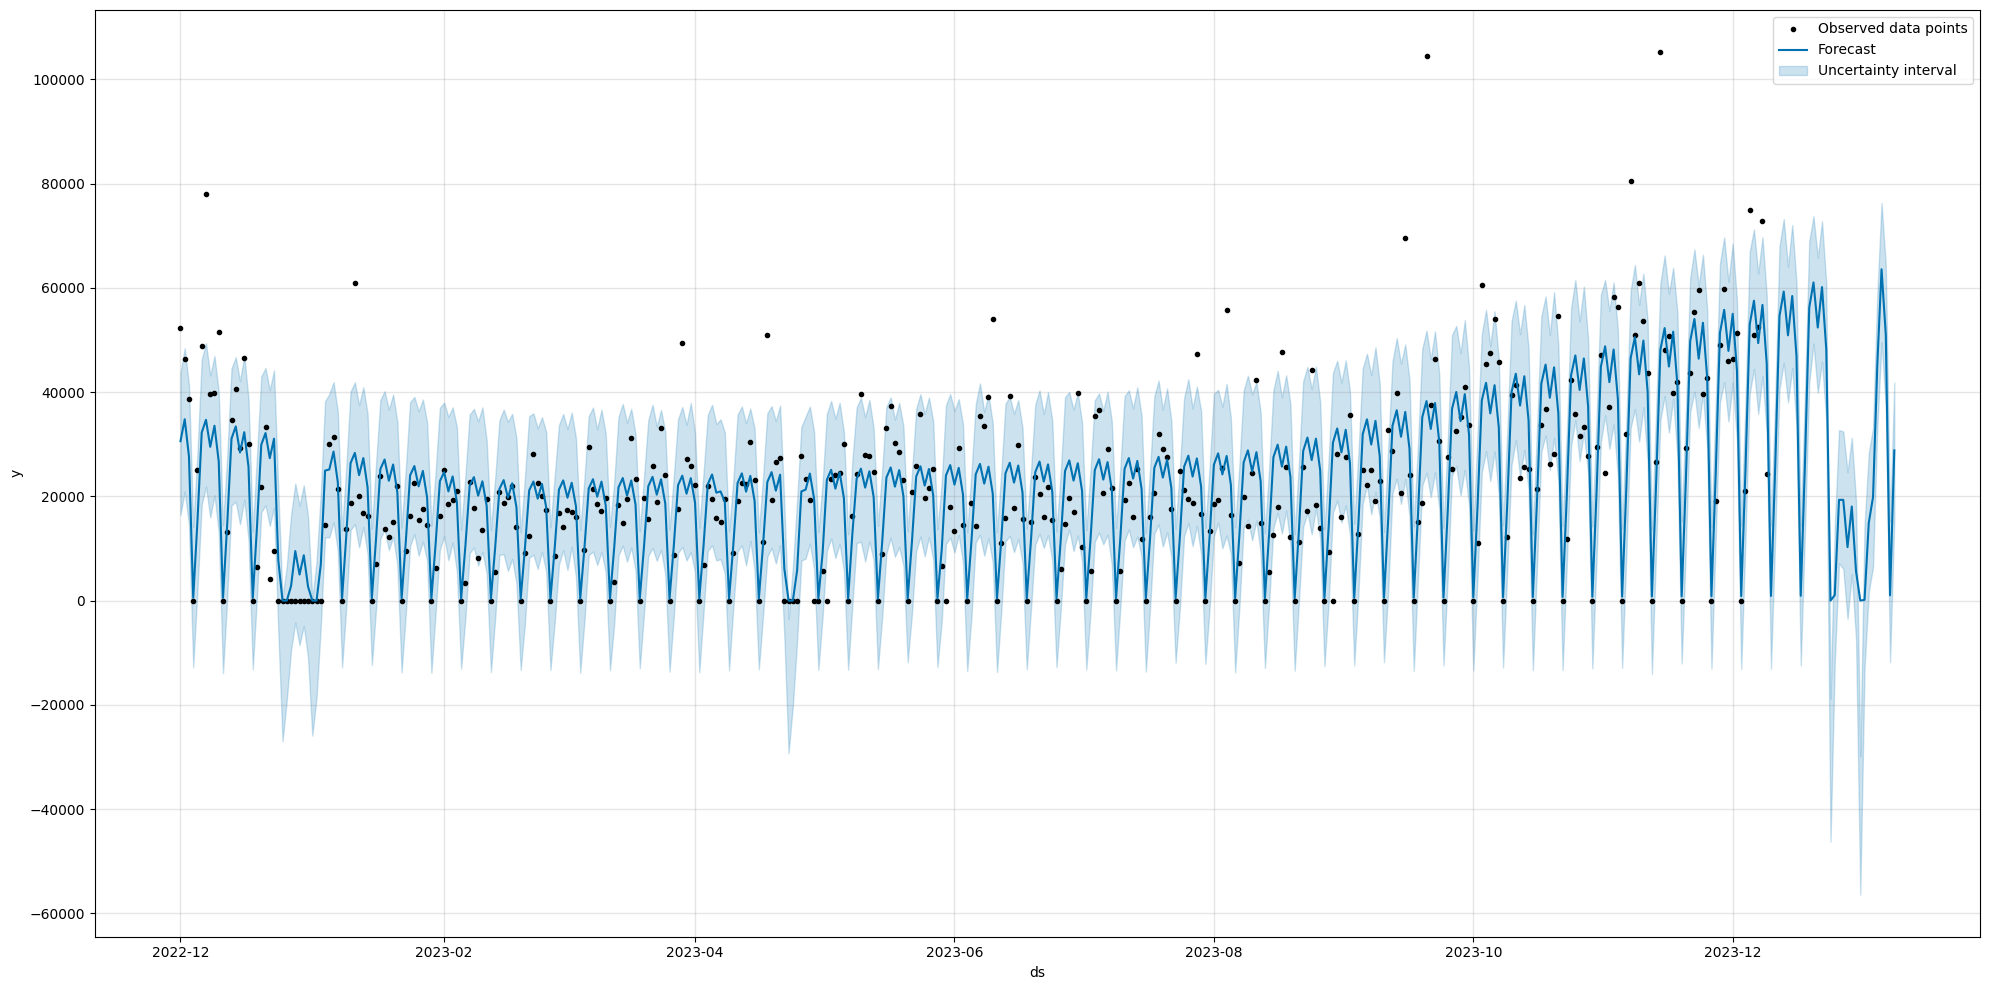

In [62]:
plt.style.use('default')


plot_forecast = plot(m, uk_forecast_df,include_legend=True
                    ,figsize=(20,10))

In [63]:
# Creación de un DataFrame para hacer predicciones para toda la serie
uk_future = m.make_future_dataframe(periods=0)  # Sin periodos futuros, solo los datos históricos
uk_forecast = m.predict(uk_future)

# Filtrar las predicciones para el periodo original
uk_forecast_original = uk_forecast[['ds', 'yhat']]

# Calcular RMSE y R²
rmse = np.sqrt(mean_squared_error(uk_prophet['y'], uk_forecast_original['yhat']))
r2 = r2_score(uk_prophet['y'], uk_forecast_original['yhat'])



print(f'RMSE: {rmse}')
print(f'R²: {r2}')

RMSE: 10462.851427852562
R²: 0.6490445568692533


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



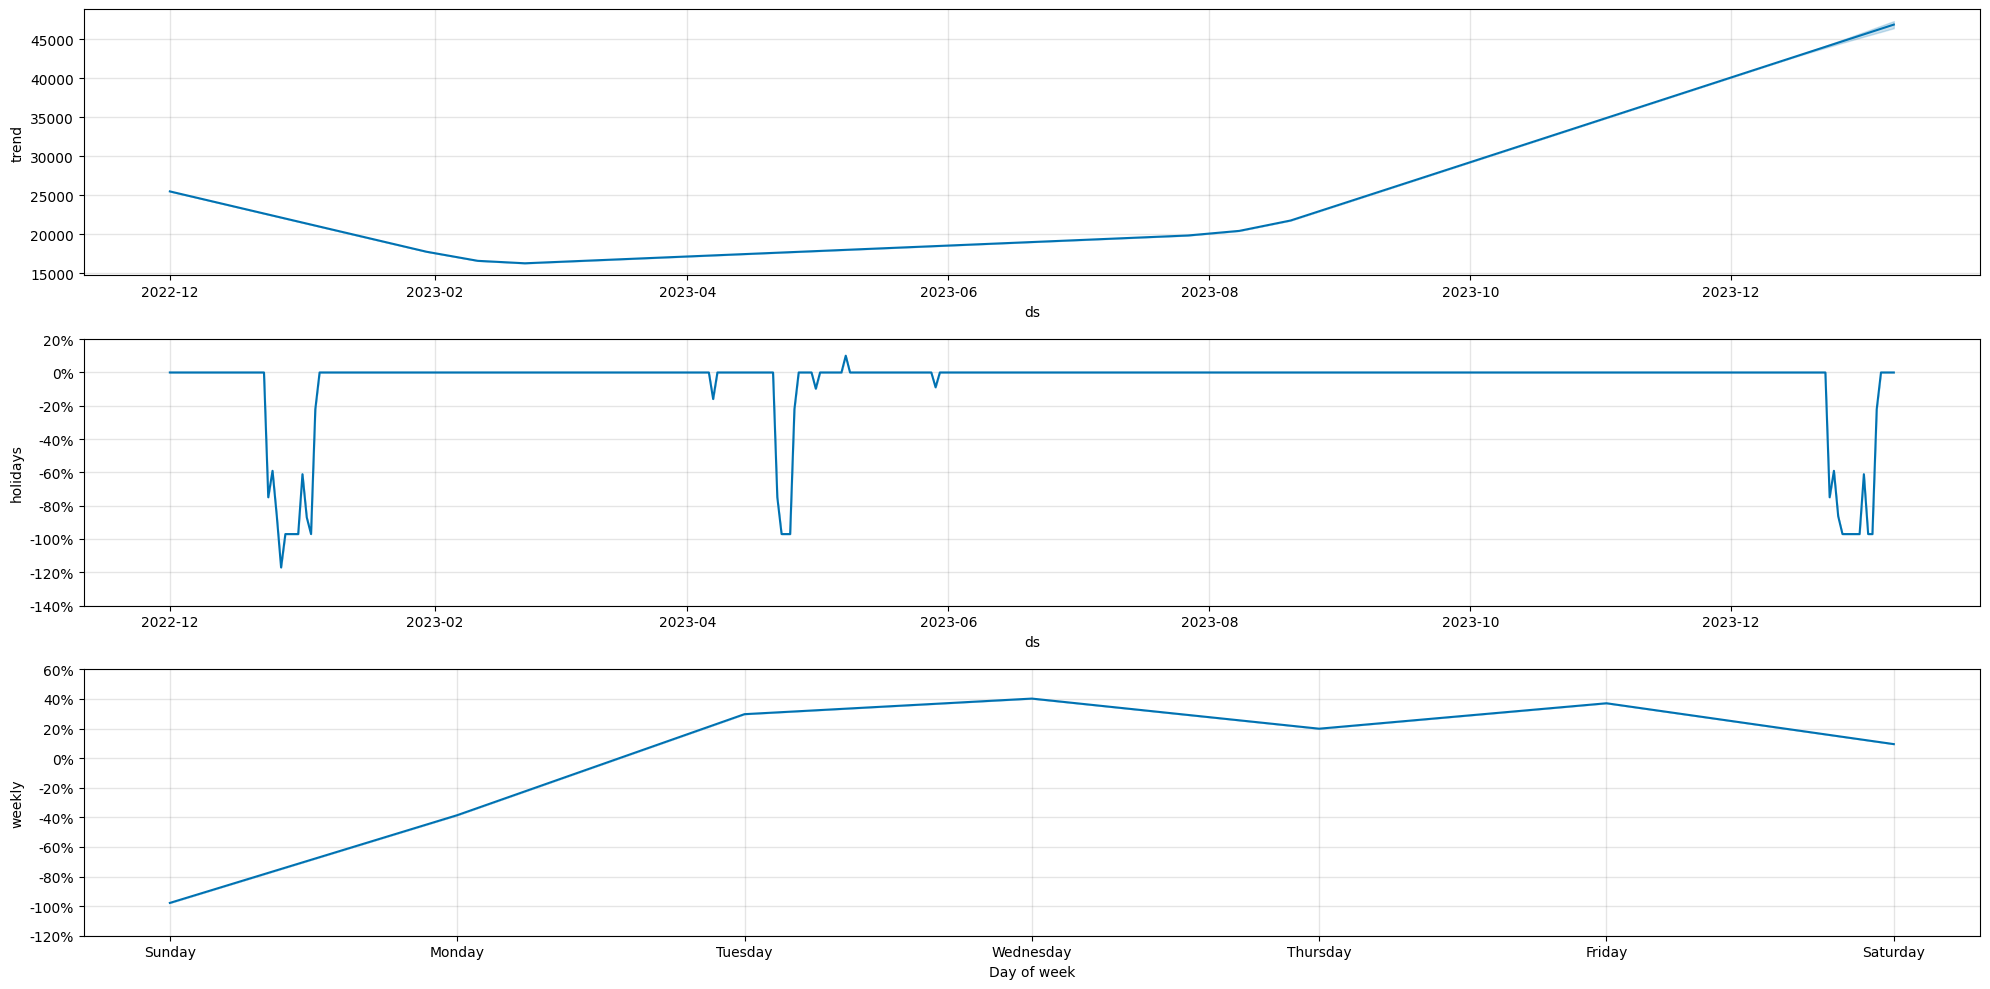

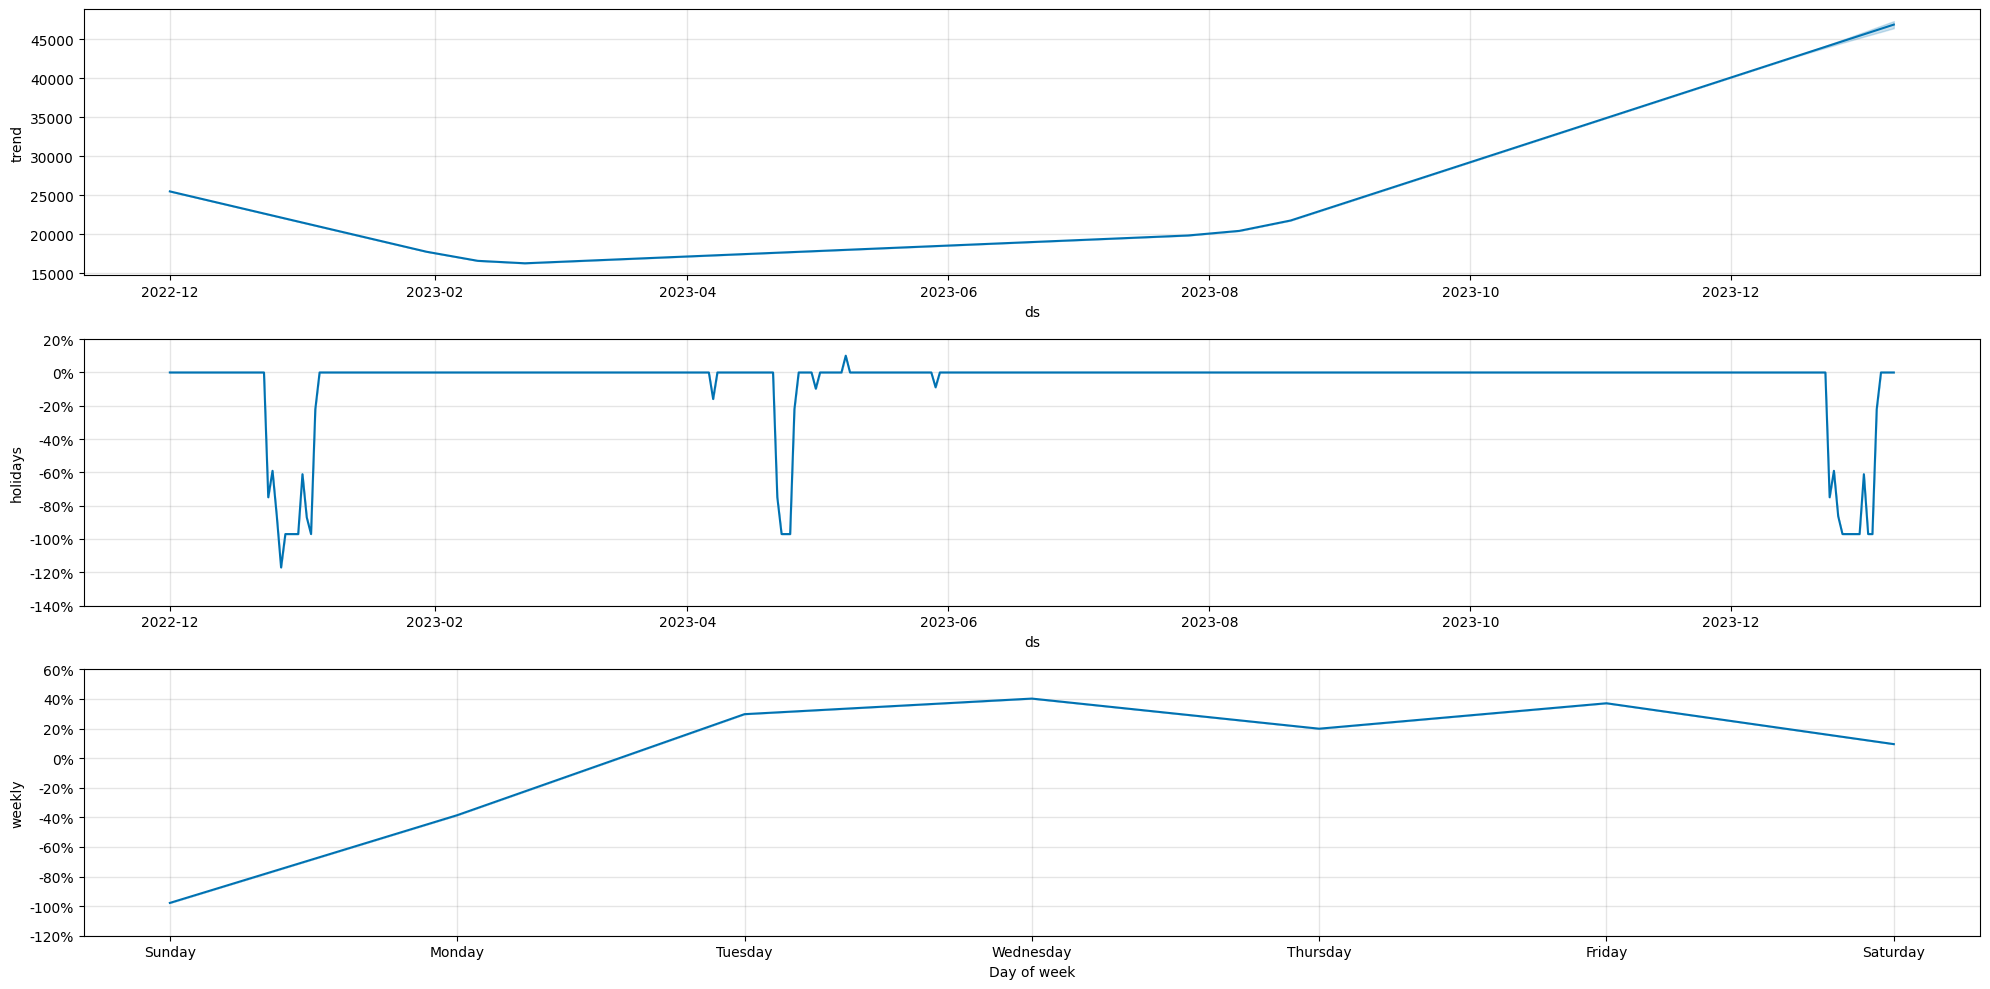

In [64]:
plot_components(m,uk_forecast_df,figsize=(20,10))

El modelo Prophet proporciona unas predicciones razonables,mejorando bastante al modelo SARIMAX y parece que el añadido de los dias de vacaciones añade un valor extra a las predicciones, capturando las principales tendencias, patrones estacionales y los dias de vacaciones . Con un R² de 0.649 y un RMSE de 10462.8, el modelo explica una parte significativa de la variabilidad en los datos.

## 2.3 Xgboost.

XGBoost (Extreme Gradient Boosting) es un algoritmo de aprendizaje supervisado basado en árboles de decisión que se utiliza principalmente para problemas de regresión y clasificación. Sin embargo, también puede adaptarse para su uso en series temporales.

Base del Algoritmo: XGBoost utiliza una técnica de ensamble conocida como boosting, donde se combinan múltiples árboles de decisión para mejorar la precisión predictiva.

Optimización: Emplea técnicas avanzadas de optimización, manejo eficiente de memoria y regularización para prevenir el sobreajuste.

Paralelismo: Aprovecha el paralelismo para acelerar el proceso de entrenamiento.

In [65]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2022-12-01 to 2023-12-09
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         374 non-null    object 
 1   DaySales        374 non-null    float64
 2   ProductsSales   374 non-null    int64  
 3   InvoiceNumbers  374 non-null    int64  
 4   diff_DaySales   373 non-null    float64
 5   Fitted          374 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 20.5+ KB


### 2.3.1 Feature Engineering

El siguiente código realiza un conjunto de transformaciones y operaciones de ingeniería de características sobre un DataFrame llamado df_uk. Estas transformaciones están orientadas a preparar los datos para su uso en modelos predictivos, especialmente en el contexto de series temporales. A continuación se describen los pasos realizados:

-  Eliminar las columnas que no se pueden usar para predicciones futuras, estas variables (Fitted, Country, ProductSales, InvoiceNumbers, diff_DaySales) son resultados de las ventas o información que no está disponible para fechas futuras,por lo que no pueden utilizarse en el modelo predictivo para nuevas fechas..
- Conversión de Índice a Datetime: Se convierte el índice del DataFrame a un objeto datetime para facilitar las operaciones basadas en tiempo.
- Creación de Columnas Temporales: Se añaden columnas adicionales para el año, mes, día de la semana y día del año basadas en el índice datetime.
- Generación de Características de Retardo: Se crea una columna con un retardo de 7 días para la serie temporal de ventas diarias.
- Cálculo de Diferenciación Absoluta y Tasa de Crecimiento: Se calculan las diferencias absolutas y la tasa de crecimiento de las ventas diarias.
- Manejo de Valores Faltantes e Infinitos: Se llenan los valores faltantes generados por las operaciones anteriores y se reemplazan los valores infinitos y extremadamente grandes.

In [66]:
df_uk

Country  DaySales  ProductsSales  InvoiceNumbers  \
Date                                                                  
2022-12-01  United Kingdom  52323.12           1060             119   
2022-12-02  United Kingdom  46407.64            749             137   
2022-12-03  United Kingdom  38721.98            855              54   
2022-12-04  United Kingdom      0.00              0               0   
2022-12-05  United Kingdom  24979.59            883              79   
...                    ...       ...            ...             ...   
2023-12-05  United Kingdom  74928.06           1468             113   
2023-12-06  United Kingdom  51020.46           1154             102   
2023-12-07  United Kingdom  52394.04            802              91   
2023-12-08  United Kingdom  72747.00           1371             113   
2023-12-09  United Kingdom  24308.93            767              35   

            diff_DaySales        Fitted  
Date                                     
2022-12-01            NaN      0.000000  
2022-12-02       -5915.48  52323.120000  
2022-12-03       -7685.66  50567.950087  
2022-12-04      -38721.98  47040.240575  
2022-12-05       24979.59  33006.466951  
...                   ...           ...  
2023-12-05       53888.80  57357.763562  
2023-12-06      -23907.60  55551.090573  
2023-12-07        1373.58  51757.235547  
2023-12-08       20352.96  49370.344914  
2023-12-09      -48438.07  56304.747023  

[374 rows x 6 columns]

In [67]:
# Eliminar la columna 'Fitted' ,"Country" "ProductSales", "InvoiceNumbers"y de la prediccion de Prophet.
df_uk = df_uk.drop(columns=['Fitted',"Country","ProductsSales","InvoiceNumbers","diff_DaySales"])

In [68]:
df_uk

DaySales
Date                
2022-12-01  52323.12
2022-12-02  46407.64
2022-12-03  38721.98
2022-12-04      0.00
2022-12-05  24979.59
...              ...
2023-12-05  74928.06
2023-12-06  51020.46
2023-12-07  52394.04
2023-12-08  72747.00
2023-12-09  24308.93

[374 rows x 1 columns]

In [69]:
# Convertir el índice a datetime
df_uk.index = pd.to_datetime(df_uk.index)

# Crear columnas de año y mes
df_uk['Year'] = df_uk.index.year
df_uk['Month'] = df_uk.index.month
df_uk['DayOfWeek'] = df_uk.index.dayofweek
df_uk['DayOfYear'] = df_uk.index.dayofyear

# Crear columna lag de 7 días
df_uk['Lag7_DaySales'] = df_uk['DaySales'].shift(7)



# Llenar valores faltantes generados por las operaciones anteriores
df_uk = df_uk.fillna(0)

# Reemplazar valores infinitos y extremadamente grandes
df_uk.replace([np.inf, -np.inf], np.nan, inplace=True)
df_uk.fillna(0, inplace=True)

### 2.3.2 Division Train/Test

In [70]:
# Dividir los datos en train y test (80% train, 20% test)
train_df, test_df = train_test_split(df_uk, test_size=0.2, shuffle=False)

# Separar las características (X) de la variable objetivo (y)
X_train = train_df.drop(columns=['DaySales'])
y_train = train_df['DaySales']
X_test = test_df.drop(columns=['DaySales'])
y_test = test_df['DaySales']

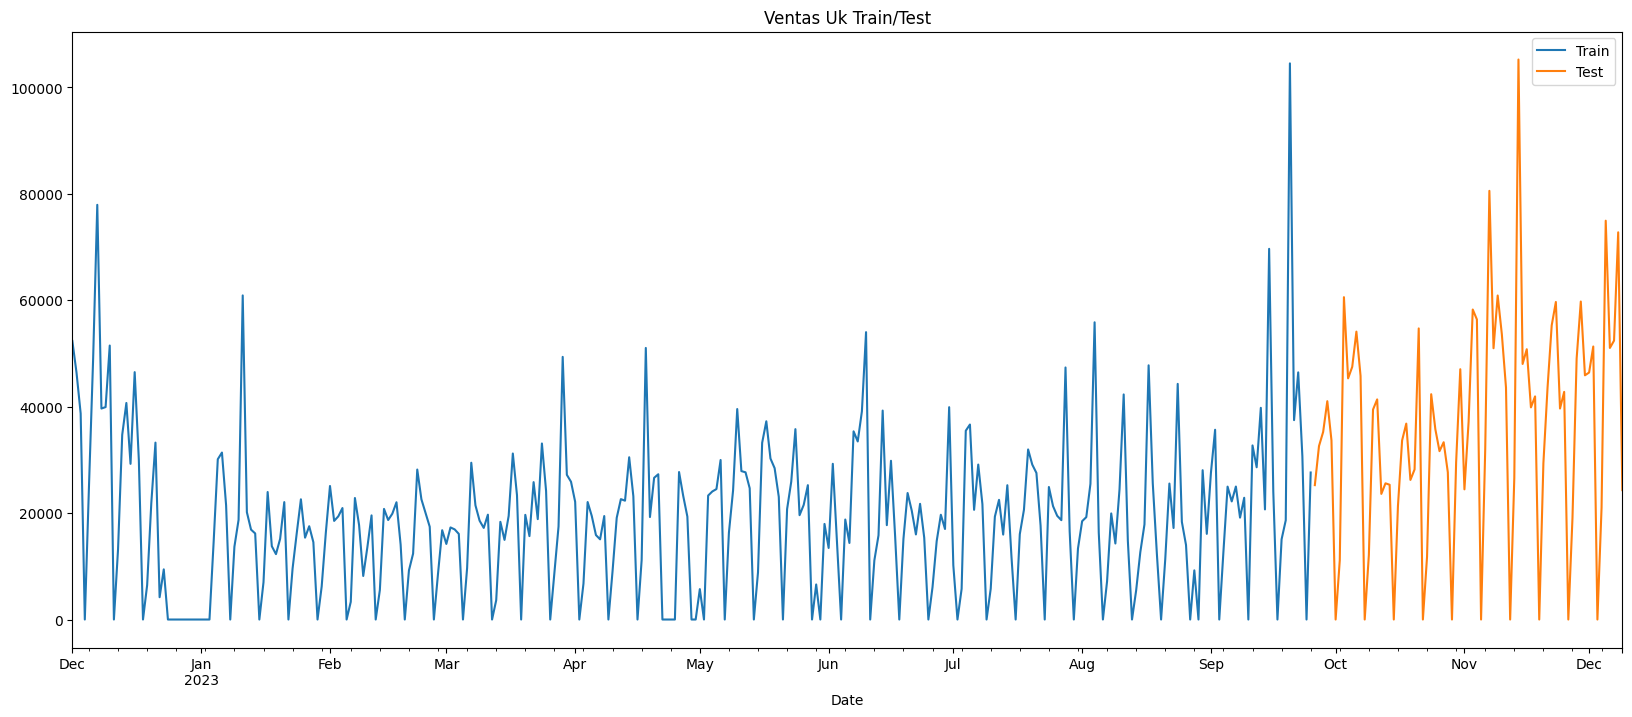

In [71]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train.plot(ax = ax , label = "Train")
y_test.plot(ax = ax , label = "Test")
ax.legend(["Train", "Test"])
plt.title("Ventas Uk Train/Test")
plt.show()

### 2.3.3 Entrenamiento del modelo.

In [72]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1300, learning_rate=0.01, early_stopping_rounds = 50)
xgb_model.fit(X_train, y_train,
            eval_set = [(X_train,y_train),(X_test,y_test)],
            verbose= 100)




[0]	validation_0-rmse:14650.91355	validation_1-rmse:27211.06567
[100]	validation_0-rmse:9200.33199	validation_1-rmse:19731.35889
[200]	validation_0-rmse:6969.80421	validation_1-rmse:18194.87242
[238]	validation_0-rmse:6302.82931	validation_1-rmse:18307.80781


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [73]:
xgb_predictions_train = xgb_model.predict(X_train)
xgb_predictions_test = xgb_model.predict(X_test)
xgb_predictions_train = pd.DataFrame(xgb_predictions_train, columns=['xgb_predictions_train'],index= X_train.index)
xgb_predictions_test = pd.DataFrame(xgb_predictions_test, columns=['xgb_predictions_test'], index= X_test.index)

In [74]:
# Calcular métricas de rendimiento para XGBoost
xgb_rmse_train = root_mean_squared_error(y_train, xgb_predictions_train)
xgb_r2_train = r2_score(y_train, xgb_predictions_train)
xgb_rmse_test = root_mean_squared_error(y_test, xgb_predictions_test)
xgb_r2_test = r2_score(y_test, xgb_predictions_test)



print("XGBoost - Train RMSE:", xgb_rmse_train, "Train R2:", xgb_r2_train)
print("XGBoost - Test RMSE:", xgb_rmse_test, "Test R2:", xgb_r2_test)

XGBoost - Train RMSE: 7220.751755890185 Train R2: 0.7600071838043356
XGBoost - Test RMSE: 18168.90882015044 Test R2: 0.2586821231344073


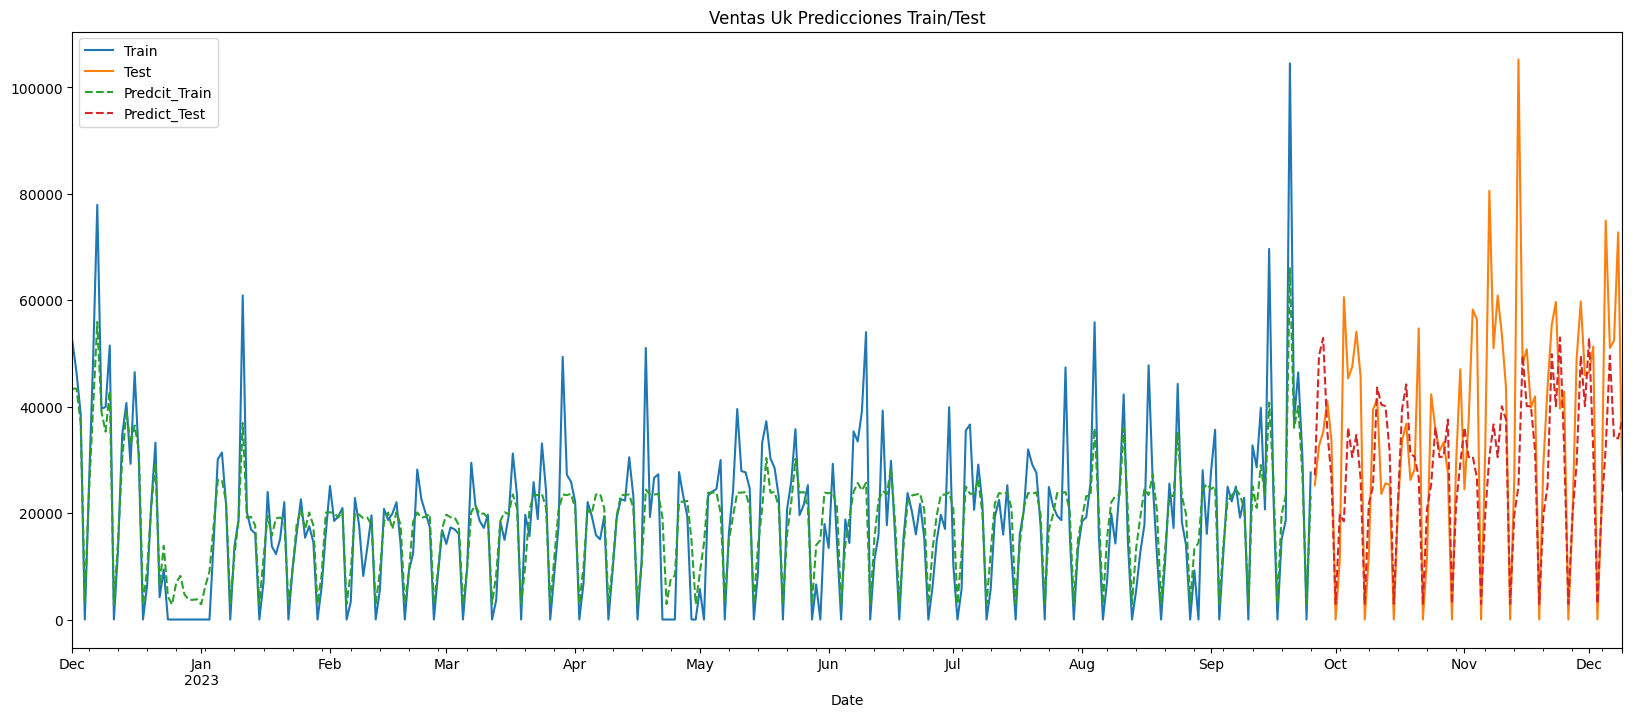

In [75]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train.plot(ax = ax , label = "Train")
y_test.plot(ax = ax , label = "Test")
xgb_predictions_train.plot(ax = ax , label = "Predic_Train", linestyle = "--")
xgb_predictions_test.plot(ax = ax, label = "Predic_Test", linestyle = "--")
ax.legend(["Train", "Test","Predcit_Train","Predict_Test"])
plt.title("Ventas Uk Predicciones Train/Test")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

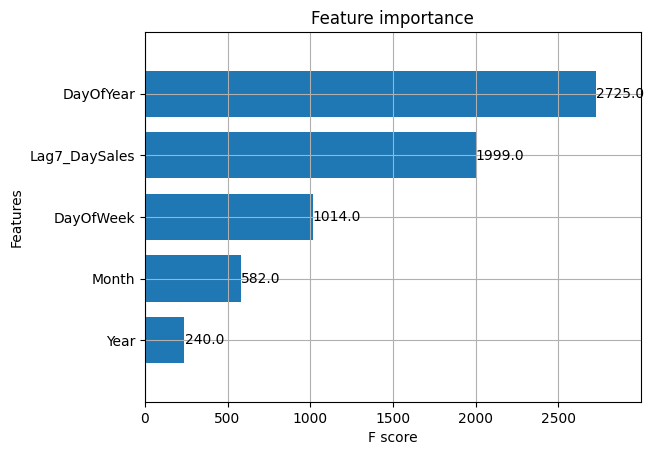

In [76]:
plot_importance(xgb_model, height = 0.75)

### 2.3.5 Prediccion XGBoost

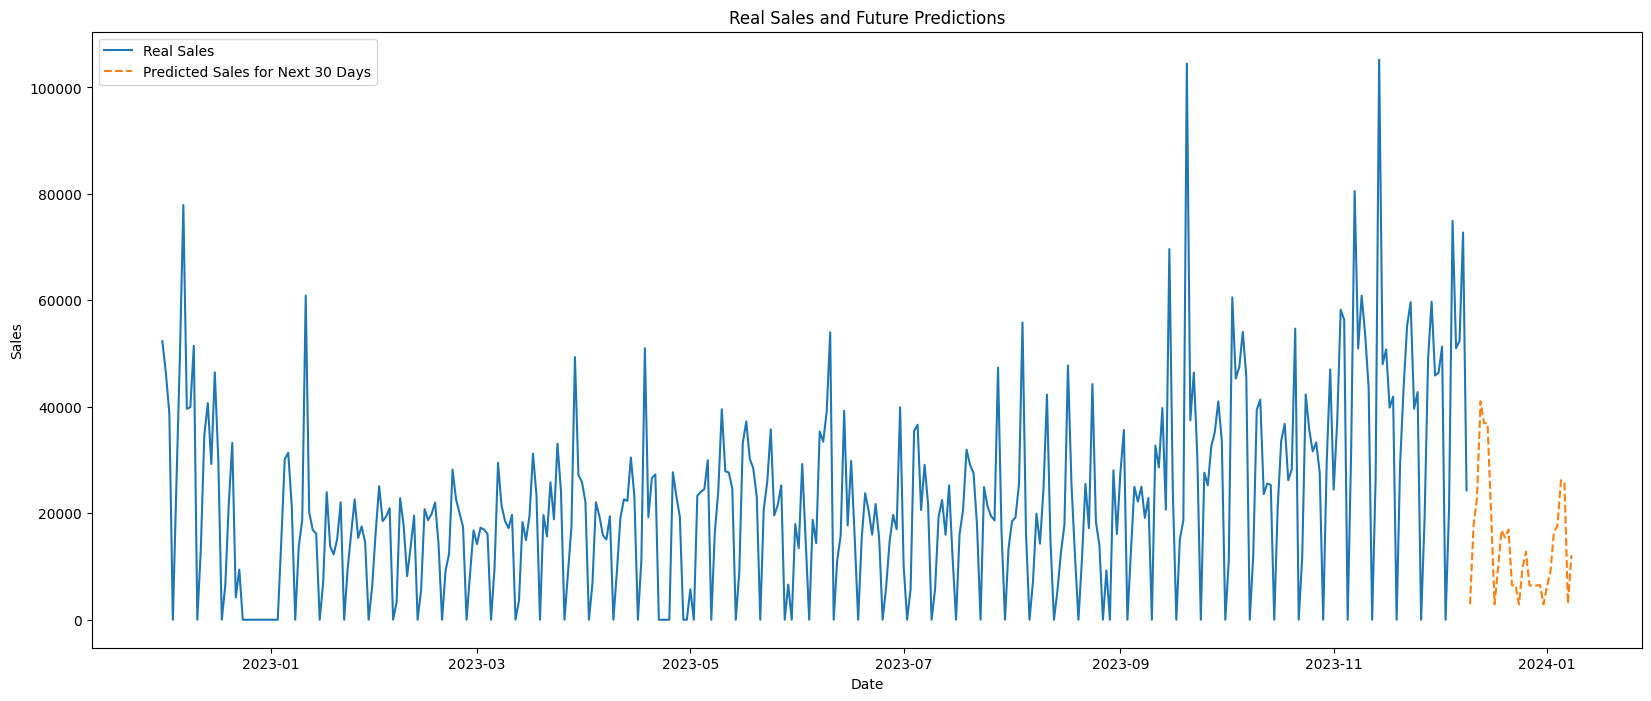

In [77]:
# Generar fechas para los próximos 30 días
last_date = df_uk.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Crear un nuevo DataFrame para los próximos 30 días
future_df = pd.DataFrame(index=future_dates)

# Llenar las nuevas fechas con características similares
future_df['Year'] = future_df.index.year
future_df['Month'] = future_df.index.month
future_df['DayOfWeek'] = future_df.index.dayofweek
future_df['DayOfYear'] = future_df.index.dayofyear

# Crear columna lag de 7 días utilizando los últimos datos conocidos
future_df['Lag7_DaySales'] = df_uk['DaySales'].iloc[-7:].tolist() + [0] * (30 - 7)

# Realizar las predicciones
future_X = future_df[['Year', 'Month', 'DayOfWeek', 'DayOfYear', 'Lag7_DaySales']]
future_predictions = xgb_model.predict(future_X)
future_predictions = pd.DataFrame(future_predictions, columns=['Future_Predictions'], index=future_dates)

# Graficar los resultados
plt.figure(figsize=(20, 8))
plt.plot(df_uk.index, df_uk['DaySales'], label='Real Sales')
plt.plot(future_predictions.index, future_predictions['Future_Predictions'], label='Predicted Sales for Next 30 Days', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Real Sales and Future Predictions')
plt.legend()
plt.show()

### 2.3.4 Xgboost con tasa de crecimiento.

In [78]:
# Tasa de crecimiento
df_uk['GrowthRate_DaySales'] = df_uk['DaySales'].pct_change()
# Llenar valores faltantes generados por las operaciones anteriores
df_uk = df_uk.fillna(0)

# Reemplazar valores infinitos y extremadamente grandes
df_uk.replace([np.inf, -np.inf], np.nan, inplace=True)
df_uk.fillna(0, inplace=True)

In [79]:
df_uk

DaySales  Year  Month  DayOfWeek  DayOfYear  Lag7_DaySales  \
Date                                                                     
2022-12-01  52323.12  2022     12          3        335           0.00   
2022-12-02  46407.64  2022     12          4        336           0.00   
2022-12-03  38721.98  2022     12          5        337           0.00   
2022-12-04      0.00  2022     12          6        338           0.00   
2022-12-05  24979.59  2022     12          0        339           0.00   
...              ...   ...    ...        ...        ...            ...   
2023-12-05  74928.06  2023     12          1        339       49031.22   
2023-12-06  51020.46  2023     12          2        340       59741.70   
2023-12-07  52394.04  2023     12          3        341       45880.52   
2023-12-08  72747.00  2023     12          4        342       46403.41   
2023-12-09  24308.93  2023     12          5        343       51295.31   

            GrowthRate_DaySales  
Date                             
2022-12-01             0.000000  
2022-12-02            -0.113057  
2022-12-03            -0.165612  
2022-12-04            -1.000000  
2022-12-05             0.000000  
...                         ...  
2023-12-05             2.561345  
2023-12-06            -0.319074  
2023-12-07             0.026922  
2023-12-08             0.388459  
2023-12-09            -0.665843  

[374 rows x 7 columns]

In [80]:
# Dividir los datos en train y test (80% train, 20% test)
train_df_g, test_df_g = train_test_split(df_uk, test_size=0.2, shuffle=False)


In [81]:
# Separar las características (X) de la variable objetivo (y)
X_train_g = train_df_g.drop(columns=['GrowthRate_DaySales'])
y_train_g = train_df_g['GrowthRate_DaySales']
X_test_g = test_df_g.drop(columns=['GrowthRate_DaySales'])
y_test_g = test_df_g['GrowthRate_DaySales']

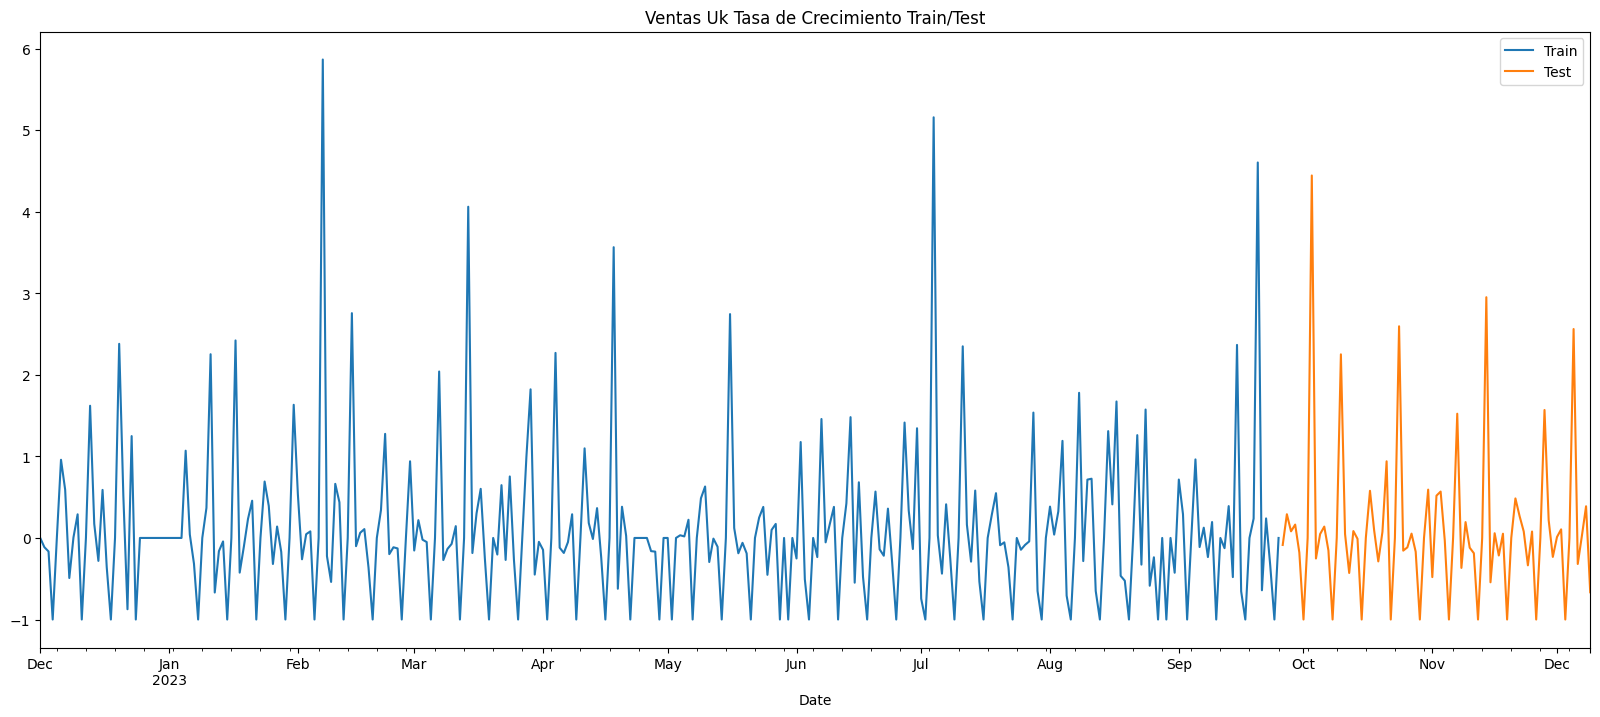

In [82]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train_g.plot(ax = ax , label = "Train")
y_test_g.plot(ax = ax , label = "Test")
ax.legend(["Train", "Test"])
plt.title("Ventas Uk Tasa de Crecimiento Train/Test")
plt.show()

In [83]:
xgb_model_g = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0  # L2 regularization
)
xgb_model_g.fit(X_train_g, y_train_g,
            eval_set = [(X_train_g,y_train_g),(X_test_g,y_test_g)],
            verbose= 100)

[0]	validation_0-rmse:0.92104	validation_1-rmse:0.92808
[49]	validation_0-rmse:0.33662	validation_1-rmse:0.71612


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [84]:
xgb_predictions_train_g = xgb_model_g.predict(X_train_g)
xgb_predictions_test_g = xgb_model_g.predict(X_test_g)
xgb_predictions_train_g = pd.DataFrame(xgb_predictions_train_g, columns=['xgb_predictions_train'],index= X_train.index)
xgb_predictions_test_g = pd.DataFrame(xgb_predictions_test_g, columns=['xgb_predictions_test'], index= X_test.index)

In [85]:
# Calcular métricas de rendimiento para XGBoost
xgb_g_rmse_train = root_mean_squared_error(y_train_g, xgb_predictions_train_g)
xgb_g_r2_train = r2_score(y_train_g, xgb_predictions_train_g)
xgb_g_rmse_test = root_mean_squared_error(y_test_g, xgb_predictions_test_g)
xgb_g_r2_test = r2_score(y_test_g, xgb_predictions_test_g)



print("XGBoost - Tasa de crecimiento Train RMSE:", xgb_g_rmse_train, "Train R2:", xgb_g_r2_train)
print("XGBoost - Tasa de crecimiento Test RMSE:", xgb_g_rmse_test, "Test R2:", xgb_g_r2_test)

XGBoost - Tasa de crecimiento Train RMSE: 0.46064979361955327 Train R2: 0.7651107183150051
XGBoost - Tasa de crecimiento Test RMSE: 0.6999897599769609 Test R2: 0.43804824598967496


In [86]:
df_uk

DaySales  Year  Month  DayOfWeek  DayOfYear  Lag7_DaySales  \
Date                                                                     
2022-12-01  52323.12  2022     12          3        335           0.00   
2022-12-02  46407.64  2022     12          4        336           0.00   
2022-12-03  38721.98  2022     12          5        337           0.00   
2022-12-04      0.00  2022     12          6        338           0.00   
2022-12-05  24979.59  2022     12          0        339           0.00   
...              ...   ...    ...        ...        ...            ...   
2023-12-05  74928.06  2023     12          1        339       49031.22   
2023-12-06  51020.46  2023     12          2        340       59741.70   
2023-12-07  52394.04  2023     12          3        341       45880.52   
2023-12-08  72747.00  2023     12          4        342       46403.41   
2023-12-09  24308.93  2023     12          5        343       51295.31   

            GrowthRate_DaySales  
Date                             
2022-12-01             0.000000  
2022-12-02            -0.113057  
2022-12-03            -0.165612  
2022-12-04            -1.000000  
2022-12-05             0.000000  
...                         ...  
2023-12-05             2.561345  
2023-12-06            -0.319074  
2023-12-07             0.026922  
2023-12-08             0.388459  
2023-12-09            -0.665843  

[374 rows x 7 columns]

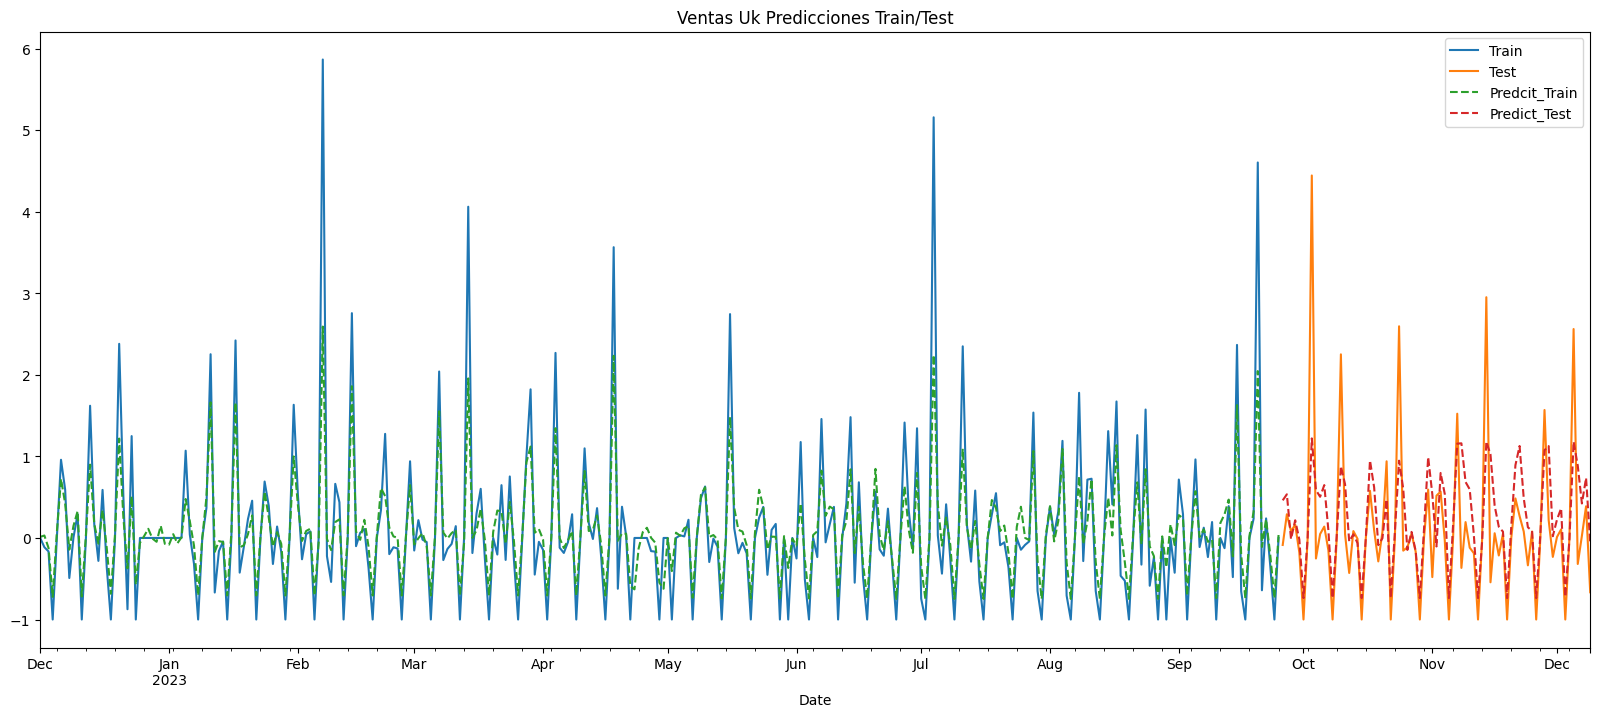

In [87]:
fig, ax = plt.subplots(figsize= (20,8), )
y_train_g.plot(ax = ax , label = "Train")
y_test_g.plot(ax = ax , label = "Test")
xgb_predictions_train_g.plot(ax = ax , label = "Predic_Train", linestyle = "--")
xgb_predictions_test_g.plot(ax = ax, label = "Predic_Test", linestyle = "--")
ax.legend(["Train", "Test","Predcit_Train","Predict_Test"])
plt.title("Ventas Uk Predicciones Train/Test")
plt.show()

In [88]:
# Unir las predicciones de entrenamiento y prueba
xgb_predictions_train_g = pd.DataFrame(xgb_predictions_train_g, columns=['xgb_predictions_train'], index=X_train_g.index)
xgb_predictions_test_g = pd.DataFrame(xgb_predictions_test_g, columns=['xgb_predictions_test'], index=X_test_g.index)

# Concatenar las predicciones
xgb_predictions_all = pd.concat([xgb_predictions_train_g, xgb_predictions_test_g])

# Asegurar que el índice de las predicciones coincide con el de df_uk
xgb_predictions_all.index = df_uk.index[:len(xgb_predictions_all)]

# Añadir las predicciones al dataframe df_uk
df_uk = df_uk.join(xgb_predictions_all)
df_uk['xgb_predictions'] = df_uk['xgb_predictions_train'].combine_first(df_uk['xgb_predictions_test'])


In [89]:
# Elimar columnas innecesarias
df_uk.drop(['xgb_predictions_train', "xgb_predictions_test"] , axis=1, inplace=True)

In [91]:
# Transformar tasa de crecimiento en la escala de valores original.
df_uk['RealPredictions'] = df_uk['DaySales'].shift(1) * (1+df_uk['xgb_predictions'])
df_uk['RealPredictions'] = df_uk['RealPredictions'].shift(-1).fillna(0)

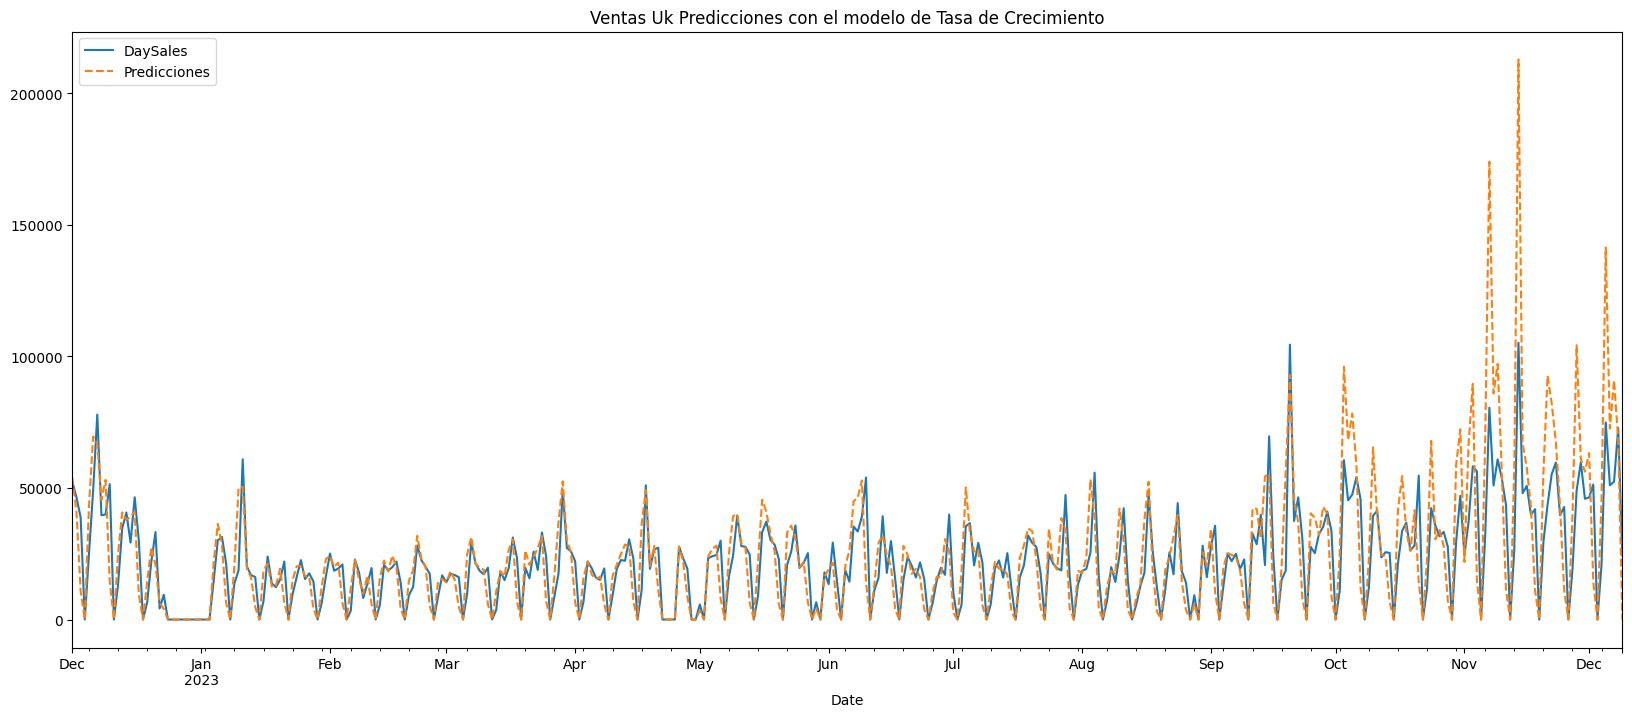

In [92]:
fig, ax = plt.subplots(figsize= (20,8), )
df_uk["DaySales"].plot(ax = ax , label = "Train")

df_uk["RealPredictions"].plot(ax = ax , label = "Predic_Train", linestyle = "--")

ax.legend(["DaySales", "Predicciones"])
plt.title("Ventas Uk Predicciones con el modelo de Tasa de Crecimiento")
plt.show()

In [93]:
df_uk

DaySales  Year  Month  DayOfWeek  DayOfYear  Lag7_DaySales  \
Date                                                                     
2022-12-01  52323.12  2022     12          3        335           0.00   
2022-12-02  46407.64  2022     12          4        336           0.00   
2022-12-03  38721.98  2022     12          5        337           0.00   
2022-12-04      0.00  2022     12          6        338           0.00   
2022-12-05  24979.59  2022     12          0        339           0.00   
...              ...   ...    ...        ...        ...            ...   
2023-12-05  74928.06  2023     12          1        339       49031.22   
2023-12-06  51020.46  2023     12          2        340       59741.70   
2023-12-07  52394.04  2023     12          3        341       45880.52   
2023-12-08  72747.00  2023     12          4        342       46403.41   
2023-12-09  24308.93  2023     12          5        343       51295.31   

            GrowthRate_DaySales  xgb_predictions  RealPredictions  
Date                                                               
2022-12-01             0.000000         0.013343     53880.836291  
2022-12-02            -0.113057         0.029771     40720.034692  
2022-12-03            -0.165612        -0.122558     10761.402951  
2022-12-04            -1.000000        -0.722085         0.000000  
2022-12-05             0.000000         0.066043     43063.937115  
...                         ...              ...              ...  
2023-12-05             2.561345         1.180839    141338.699704  
2023-12-06            -0.319074         0.886325     72596.335454  
2023-12-07             0.026922         0.422887     90966.299842  
2023-12-08             0.388459         0.736196     68281.882444  
2023-12-09            -0.665843        -0.061379         0.000000  

[374 rows x 9 columns]

In [94]:
# Calcular métricas de rendimiento para XGBoost
from sklearn.metrics import r2_score
xgb_g_rmse = root_mean_squared_error(df_uk["DaySales"], df_uk["RealPredictions"])
xgb_g_r2 = r2_score(df_uk["DaySales"], df_uk["RealPredictions"])

print("XGBoost - Tasa de Crecimiento RMSE:", xgb_g_rmse, "R2:", xgb_g_r2)


XGBoost - Tasa de Crecimiento RMSE: 15363.371184931317 R2: 0.24329794658450665



# 3 . Análisis de Resultados y Selección de Modelo


En el análisis de diferentes modelos de predicción para el conjunto de datos proporcionado, se evaluaron las métricas de rendimiento de XGBoost (con valores reales y con tasas de crecimiento), SARIMAX y Prophet. A continuación, se presentan las conclusiones basadas en las métricas obtenidas:

**XGBoost con Valores Reales**:

Train RMSE: 7220.75

Train R²: 0.76

Test RMSE: 18168.91

Test R²: 0.26

El modelo XGBoost con valores reales muestra un buen rendimiento en el conjunto de entrenamiento, con un RMSE relativamente bajo y un R² alto. Sin embargo, su desempeño en el conjunto de prueba es significativamente peor, lo que indica una posible sobreajuste (overfitting).

**XGBoost con Tasas de Crecimiento**

Train RMSE: 0.4606

Train R²: 0.77

Test RMSE: 0.6999

Test R²: 0.44

El modelo XGBoost utilizando tasas de crecimiento presenta un mejor equilibrio entre los conjuntos de entrenamiento y prueba en comparación con el modelo con valores reales. Aunque el RMSE y el R² en el conjunto de prueba son más bajos, este modelo muestra una mayor capacidad para generalizar.

**XGBoost con Tasa de Crecimiento Total**

RMSE: 17744.16

R²: 0.24

Esta variante de XGBoost no parece ofrecer una mejora significativa respecto a los otros modelos, con un RMSE alto y un R² bajo.

**SARIMAX**

RMSE: 12799.77

R²: 0.47

El modelo SARIMAX ofrece un rendimiento intermedio con un RMSE moderado y un R² relativamente aceptable. No obstante, sus métricas son inferiores a las del modelo Prophet.

**Prophet**

RMSE: 10462.85

R²: 0.65

El modelo Prophet muestra el mejor rendimiento entre todos los modelos evaluados. Su RMSE es el más bajo y su R² es el más alto, lo que indica una mayor precisión y capacidad predictiva.

Decisión Final

Dado el análisis de las métricas obtenidas, se concluye que el modelo Prophet es la mejor opción para la predicción en este conjunto de datos. Sus métricas de RMSE y R² son las más favorables, lo que sugiere que este modelo tiene la mayor precisión y capacidad de generalización.

Por lo tanto, se recomienda utilizar el modelo Prophet para futuras predicciones.



# 4. Conclusiones del Análisis de Series Temporales

## Resumen del Trabajo

En el análisis de series temporales realizado, se han utilizado datos de ventas diarias para diferentes países, pero debido a la falta de datos en muchos de ellos, nos centramos exclusivamente en el análisis del Reino Unido (UK). A través de varios modelos de predicción, destacando el modelo Prophet, se observó una tendencia ligeramente ascendente en las ventas futuras en el Reino Unido. Sin embargo, los resultados no son lo suficientemente representativos para justificar una ampliación de capital como se sugería en el enunciado del problema.

## Predicciones y Análisis de UK

- **Modelo Utilizado**: Prophet
- **Métricas de Evaluación**:
  - **RMSE**: 10462.85
  - **R²**: 0.65
- **Tendencia Predicha**: Ligeramente ascendente

Las predicciones obtenidas con el modelo Prophet indican una leve tendencia al alza en las ventas futuras del Reino Unido. Sin embargo, dada la variabilidad y la magnitud de los errores (RMSE), estos resultados no son lo suficientemente sólidos para basar decisiones estratégicas de gran envergadura como una ampliación de capital.

## Recomendaciones Estratégicas

1. **Expandir el Análisis a Otros Países**:
   - **Recolección de Datos**: Es crucial mejorar la recolección de datos en otros países para obtener un análisis más representativo y comprensivo.
   - **Predicciones Localizadas**: Realizar predicciones individualizadas para cada país una vez que se disponga de datos suficientes.

2. **Inversión en Marketing y Ventas Internacionales**:
   - **Marketing en Otros Países**: Dado que la diferencia en ventas entre el Reino Unido y otros países es notable, se recomienda invertir en estrategias de marketing específicas para mercados internacionales.
   - **Estrategias de Expansión**: Considerar campañas de marketing localizadas y alianzas estratégicas para aumentar la presencia y las ventas en estos países.

3. **Monitoreo Continuo y Ajustes**:
   - **Actualización Periódica de Datos**: Implementar un sistema de monitoreo continuo de las ventas y ajustar las estrategias de marketing y ventas en función de los datos más recientes.
   - **Reentrenamiento de Modelos**: Reentrenar los modelos predictivos a medida que se recopilan más datos para mejorar la precisión de las predicciones.

4. **Investigación de Mercados**:
   - **Estudios de Mercado**: Realizar estudios de mercado detallados para comprender mejor las preferencias y comportamientos de los consumidores en diferentes países.
   - **Adaptación de Productos**: Adaptar los productos y servicios para satisfacer las necesidades específicas de cada mercado.

## Conclusión

El análisis de las series temporales, aunque centrado en el Reino Unido debido a la falta de datos en otros países, nos ha proporcionado información valiosa. Las predicciones del modelo Prophet sugieren una ligera tendencia ascendente en las ventas, pero no es lo suficientemente significativa como para justificar una ampliación de capital en este momento. En su lugar, se recomienda una estrategia enfocada en mejorar la recolección de datos y fortalecer las ventas a través de marketing y estrategias específicas en mercados internacionales.
